# Optimization Based Accident Prediction and Policy Design
## 15.095 Machine Learning Under a Modern Optimization Lens
### Riya Parikh and Ayela Chughtai

# PREDICTION

# Data Cleaning - Creating a smaller data subset

In [20]:
# Load libraries

using CSV, DataFrames, Dates, Statistics, CategoricalArrays

In [21]:
# Load data

df = CSV.read("US_Accidents_March23.csv", DataFrame)
first(df, 1)

1×46 DataFrame
 Row │ ID        Source   Severity  Start_Time           End_Time              ⋯
     │ String15  String7  Int64     String31             String31              ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ A-1       Source2         3  2016-02-08 05:46:00  2016-02-08 11:00:00   ⋯
                                                              41 columns omitted

In [22]:
# drop missing values

df_dropna = dropmissing(df)

# figuring out which city to hone in on by counting number of accidents per city
# we want to hone in on one city so we can go by specific coordinates for the geographic map

accidents_by_city = sort!(
    combine(groupby(df_dropna, :City), nrow => :Count),
    :Count,
    rev = true,
)

10327×2 DataFrame
   Row │ City                          Count
       │ String                        Int64
───────┼──────────────────────────────────────
     1 │ Miami                         142575
     2 │ Los Angeles                    79444
     3 │ Orlando                        74911
     4 │ Dallas                         50074
     5 │ Houston                        46197
     6 │ Charlotte                      40228
     7 │ San Diego                      32473
     8 │ Raleigh                        31438
     9 │ Nashville                      28555
    10 │ Sacramento                     28421
    11 │ Baton Rouge                    26963
   ⋮   │              ⋮                  ⋮
 10318 │ Lynn Center                        1
 10319 │ Lublin                             1
 10320 │ Fairbank                           1
 10321 │ Pond Eddy                          1
 10322 │ Ness City                          1
 10323 │ Calumet Park                       1
 10324 │ Clarksdale                         1
 10325 │ Bridgeboro                         1
 10326 │ Tylertown                          1
 10327 │ American Fork-Pleasant Grove       1
                            10306 rows omitted

In [23]:
# selecting miami because it has the most data available

df_miami = df_dropna[lowercase.(df_dropna.City) .== "miami", :]
first(df_miami, 1)

1×46 DataFrame
 Row │ ID         Source   Severity  Start_Time                     End_Time   ⋯
     │ String15   String7  Int64     String31                       String31   ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ A-3654889  Source1         2  2023-02-27 09:06:07.000000000  2023-02-27 ⋯
                                                              42 columns omitted

In [24]:
# If Start_Time sometimes has fractional seconds, strip them first
clean_start = replace.(df_miami.Start_Time, r"\.\d+" => "")

# Parse to DateTime (format: 2023-02-26 17:20:59)
dt = DateTime.(clean_start, dateformat"yyyy-mm-dd HH:MM:SS")

# Add Year and Month and Time columns

df_miami.Year  = year.(dt)
df_miami.Month = month.(dt)
df_miami.DayOfWeek = dayname.(dt)
df_miami.DayOfWeek = categorical(df_miami.DayOfWeek)
df_miami.StartHour = hour.(dt)

first(df_miami, 1)

1×50 DataFrame
 Row │ ID         Source   Severity  Start_Time                     End_Time   ⋯
     │ String15   String7  Int64     String31                       String31   ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ A-3654889  Source1         2  2023-02-27 09:06:07.000000000  2023-02-27 ⋯
                                                              46 columns omitted

In [25]:
# fix start and end times for logical consistency because some end times have the wrong year 

function fix_end_time(start_str::AbstractString, end_str::AbstractString)
    pattern = r"(\d{4})-(\d{2})-(\d{2}) (\d{2}):(\d{2}):(\d{2})"

    m_start = match(pattern, start_str)
    m_end   = match(pattern, end_str)

    y_start = parse(Int, m_start.captures[1])

    y_end   = parse(Int, m_end.captures[1])
    mm      = parse(Int, m_end.captures[2])
    dd      = parse(Int, m_end.captures[3])
    hh      = parse(Int, m_end.captures[4])
    min     = parse(Int, m_end.captures[5])
    ss      = parse(Int, m_end.captures[6])

    if y_start == y_end
        return end_str
    end

    corrected = DateTime(y_start, mm, dd, hh, min, ss)
    return string(corrected)
end

df_miami.End_Time = fix_end_time.(df_miami.Start_Time, df_miami.End_Time)
first(df_miami, 1)

1×50 DataFrame
 Row │ ID         Source   Severity  Start_Time                     End_Time   ⋯
     │ String15   String7  Int64     String31                       Abstract…  ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ A-3654889  Source1         2  2023-02-27 09:06:07.000000000  2023-02-27 ⋯
                                                              46 columns omitted

In [26]:
# calculate duration of accident

function normalize_time(s::AbstractString)
    s = String(strip(s))

    # Replace ANY whitespace (tabs, unicode spaces) with a single normal space
    s = replace(s, r"\s" => " ")

    # Replace T separator with a space
    s = replace(s, "T" => " ")

    # Remove timezone if present (+00:00 or -05:00)
    s = replace(s, r"\s*\+\d\d:\d\d" => "")

    # Remove fractional seconds (e.g. .000000000)
    s = replace(s, r"\.\d+" => "")

    # FIX: Ensure correct spacing between date and time
    # (e.g. "2023-02-27 09:06:07" is good)
    s = replace(s, r"^(\d{4}-\d{2}-\d{2})\s*(\d{2}:\d{2}:\d{2})$" => s"\1 \2")

    # Add seconds if missing (HH:MM → HH:MM:SS)
    if occursin(r"^\d{4}-\d{2}-\d{2} \d{2}:\d{2}$", s)
        s *= ":00"
    end

    # Now parse safely
    return DateTime(s, dateformat"yyyy-mm-dd HH:MM:SS")
end

# normalizer
df_miami.StartDT = normalize_time.(df_miami.Start_Time)
df_miami.EndDT   = normalize_time.(df_miami.End_Time)

# convert back to uniform string format
df_miami.Start_Time = Dates.format.(df_miami.StartDT, "yyyy-mm-dd HH:MM:SS")
df_miami.End_Time   = Dates.format.(df_miami.EndDT,   "yyyy-mm-dd HH:MM:SS")

# compute durations
df_miami.Duration = df_miami.EndDT .- df_miami.StartDT
df_miami.DurationMinutes = round.(Int, Dates.value.(df_miami.Duration) ./ 60000)
first(df_miami, 1)

1×54 DataFrame
 Row │ ID         Source   Severity  Start_Time           End_Time             ⋯
     │ String15   String7  Int64     String               String               ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ A-3654889  Source1         2  2023-02-27 09:06:07  2023-02-27 15:06:06  ⋯
                                                              49 columns omitted

In [27]:
# severity 
# high = 3,4 = true
# low = 1,2 = false

df_miami.HighSeverity = df_miami.Severity .>= 3

first(df_miami, 1)

1×55 DataFrame
 Row │ ID         Source   Severity  Start_Time           End_Time             ⋯
     │ String15   String7  Int64     String               String               ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ A-3654889  Source1         2  2023-02-27 09:06:07  2023-02-27 15:06:06  ⋯
                                                              50 columns omitted

In [28]:
# miami occurs in both AZ and FL - keep only FL rows
df_miami = df_miami[df_miami.State .== "FL", :]

# drop state column
select!(df_miami, Not(:State))

# drop other unwanted columns
drop_cols = [
    :ID, 
    :Source,
    :Severity,
    :Start_Time,
    :End_Time,
    :City,
    :Country,
    :Weather_Timestamp,
    :Zipcode,
    :Timezone
]

select!(df_miami, Not(drop_cols))
first(df_miami, 1)

1×44 DataFrame
 Row │ Start_Lat  Start_Lng  End_Lat  End_Lng   Distance(mi)  Description  Str ⋯
     │ Float64    Float64    Float64  Float64   Float64       String       Str ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │   25.8489   -80.2077  25.8489  -80.2079         0.011  Accident     I-9 ⋯
                                                              38 columns omitted

In [29]:
# Build a geographic decision grid, about 1 sq. km

# Choose grid resolution
grid_size = 0.01   # degrees (approx. 1 km)

# Create binned coordinates
df_miami.lat_bin = round.(df_miami.Start_Lat ./ grid_size) .* grid_size
df_miami.lng_bin = round.(df_miami.Start_Lng ./ grid_size) .* grid_size

# Create unique identifier
df_miami.location_id = string.(df_miami.lat_bin) .* "_" .* string.(df_miami.lng_bin)
first(df_miami, 1)

1×47 DataFrame
 Row │ Start_Lat  Start_Lng  End_Lat  End_Lng   Distance(mi)  Description  Str ⋯
     │ Float64    Float64    Float64  Float64   Float64       String       Str ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │   25.8489   -80.2077  25.8489  -80.2079         0.011  Accident     I-9 ⋯
                                                              41 columns omitted

In [30]:
# change column names to symbols
rename!(df_miami, Symbol.(string.(names(df_miami))); makeunique=true)
first(df_miami, 1)

1×47 DataFrame
 Row │ Start_Lat  Start_Lng  End_Lat  End_Lng   Distance(mi)  Description  Str ⋯
     │ Float64    Float64    Float64  Float64   Float64       String       Str ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │   25.8489   -80.2077  25.8489  -80.2079         0.011  Accident     I-9 ⋯
                                                              41 columns omitted

In [31]:
# decide which columns to drop

# datetime and duration columns
# think its best to only keep duration minutes as its cleanest
cols_to_drop = [
    :StartDT, :EndDT, :Duration, :Description, :Street
]

# drop other unwanted columns bc high cardinality or unused
# description seems too text-heavy to me
# street will hv extremely high cardinality
# these will end up becoming soooo many dummies

select!(df_miami, Not(cols_to_drop))
first(df_miami, 1)

1×42 DataFrame
 Row │ Start_Lat  Start_Lng  End_Lat  End_Lng   Distance(mi)  County      Airp ⋯
     │ Float64    Float64    Float64  Float64   Float64       String31    Stri ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │   25.8489   -80.2077  25.8489  -80.2079         0.011  Miami-Dade  KOPF ⋯
                                                              36 columns omitted

In [32]:
# Columns to model
numeric_cols = Symbol.([
    "Start_Lat", "Start_Lng", "End_Lat", "End_Lng",
    "Distance(mi)",
    "Temperature(F)", "Wind_Chill(F)",
    "Humidity(%)", "Pressure(in)", "Visibility(mi)",
    "Wind_Speed(mph)", "Precipitation(in)",
    "DurationMinutes",
])

# Coerce numerics to Float64 where present
for c in numeric_cols
    if hasproperty(df_miami, c)
        df_miami[!, c] = Float64.(df_miami[!, c])
    end
end

In [33]:
# Core categoricals
cat_cols = Symbol[
    :DayOfWeek,
    :County, :Airport_Code, :Wind_Direction, :Weather_Condition,
    :Sunrise_Sunset, :Civil_Twilight, :Nautical_Twilight, :Astronomical_Twilight]

# Coerce to categorical with stable levels (esp. DayOfWeek)
weekday_levels = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
for c in cat_cols
    if hasproperty(df_miami, c)
        if c == :DayOfWeek
            df_miami[!, c] = categorical(String.(df_miami[!, c]), ordered=true, levels=weekday_levels)
        elseif c in (:Year, :Month, :StartHour)
            df_miami[!, c] = categorical(string.(df_miami[!, c]))  # treat calendar ints as categories
        else
            df_miami[!, c] = categorical(String.(df_miami[!, c]))
        end
    end
end

# helper to make safe dummy names
_clean(s::AbstractString) = begin
    x = replace(s, r"[^0-9A-Za-z]+" => "_")
    x = replace(x, r"_+" => "_")
    strip(x, '_')
end

# One-hot encode IN PLACE (Int 0/1), drop originals
function one_hot_inplace!(df::DataFrame, cols::Vector{Symbol}; drop_first::Bool=true, prefix::AbstractString="__")
    for col in cols
        hasproperty(df, col) || continue
        vals = df[!, col]

        # stable level order
        lvls = vals isa CategoricalVector ? collect(levels(vals)) :
                                            sort(unique(String.(vals)))

        use_lvls = (drop_first && length(lvls) > 1) ? lvls[2:end] : lvls
        for lvl in use_lvls
            newname = Symbol(string(col) * prefix * _clean(string(lvl)))
            df[!, newname] = Int.(coalesce.(vals .== lvl, false))  # 0/1, missings -> 0
        end

        DataFrames.select!(df, DataFrames.Not(col))  # drop original
    end
    return df
end

# Apply to ALL categoricals
one_hot_inplace!(df_miami, cat_cols; drop_first=true, prefix="__")

first(df_miami, 1)


1×92 DataFrame
 Row │ Start_Lat  Start_Lng  End_Lat  End_Lng   Distance(mi)  Temperature(F)   ⋯
     │ Float64    Float64    Float64  Float64   Float64       Float64          ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │   25.8489   -80.2077  25.8489  -80.2079         0.011            75.0   ⋯
                                                              86 columns omitted

In [34]:
# Booleans to 0/1

bool_cols = [:Amenity, :Bump, :Crossing, :Give_Way, :Junction, :No_Exit, :Railway, :Roundabout, 
    :Station, :Stop, :Traffic_Calming, :Traffic_Signal, :Turning_Loop]

for c in bool_cols
    if hasproperty(df_miami, c)
        df_miami[!, c] = Int.(df_miami[!, c])
    end
end

In [35]:
# make clean 0/1 target
df_miami[!, :HighSeverity_int] = Int.(Bool.(coalesce.(df_miami[!, :HighSeverity], false)))

# keep a categorical label version for MLJ pipelines
df_miami[!, :HighSeverity] = categorical(ifelse.(df_miami.HighSeverity_int .== 1, "1", "0"))

println("Final column count: ", size(df_miami, 2))
println("Final row count: ", size(df_miami, 1))

Final column count: 93
Final row count: 142511


In [36]:
first(df_miami, 1)

1×93 DataFrame
 Row │ Start_Lat  Start_Lng  End_Lat  End_Lng   Distance(mi)  Temperature(F)   ⋯
     │ Float64    Float64    Float64  Float64   Float64       Float64          ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │   25.8489   -80.2077  25.8489  -80.2079         0.011            75.0   ⋯
                                                              87 columns omitted

In [41]:
# divide into train and test

train_df = df_miami[df_miami.Year .< 2023, :]
test_df  = df_miami[df_miami.Year .== 2023, :]

# standardize
for c in numeric_cols
    μ = mean(train_df[!, c])
    σ = std(train_df[!, c])
    σ = σ == 0 ? 1.0 : σ

    train_df[!, c] = (train_df[!, c] .- μ) ./ σ
    test_df[!,  c] = (test_df[!, c]  .- μ) ./ σ
end

In [42]:
train_df

137343×93 DataFrame
    Row │ Start_Lat    Start_Lng   End_Lat     End_Lng     Distance(mi)  Tempe ⋯
        │ Float64      Float64     Float64     Float64     Float64       Float ⋯
────────┼───────────────────────────────────────────────────────────────────────
      1 │ -0.0717282    0.0327159  -0.105468    0.0336114   -0.25335           ⋯
      2 │ -1.9575      -1.07442    -1.99937    -1.06872     -0.0669115
      3 │ -1.9575      -1.07442    -1.94847    -1.06935     -0.421649
      4 │ -0.893256    -1.11702    -0.877439   -1.09484     -0.336996
      5 │ -0.684251    -1.31157    -0.678222   -1.32126     -0.369245          ⋯
      6 │ -0.263022    -0.56969    -0.265049   -0.553317    -0.385369
      7 │ -0.263668    -0.59888    -0.265788   -0.586792    -0.408548
      8 │  0.00366586  -1.31744    -0.0107675  -1.31148     -0.393432
      9 │  1.88179      1.01893     1.85594     1.00445     -0.408548          ⋯
     10 │ -0.867153    -0.650233   -0.880834   -0.703926    -0.13544
     11 │ -1.31627     -0.333589   -1.39369    -0.379387     0.187049
   ⋮    │      ⋮           ⋮           ⋮           ⋮            ⋮              ⋱
 137334 │  1.26492      1.15593     1.24743     1.14979     -0.458937
 137335 │  0.647163    -0.180722    0.700297   -0.182421    -0.00946817        ⋯
 137336 │  1.73909      1.43179     1.68924     1.40414     -0.238234
 137337 │  0.113867     0.755358    0.109108    0.825516    -0.0659037
 137338 │ -0.658158     0.25711    -0.659338    0.251516    -0.430719
 137339 │ -0.661779     0.254097   -0.654914    0.260687    -0.401494          ⋯
 137340 │  1.37397      1.15395     1.38506     1.14984     -0.252343
 137341 │  1.55533      1.12032     1.53496     1.11436     -0.458937
 137342 │  0.394202     0.825373    0.387426    0.748255    -0.073966
 137343 │  1.64186      1.28126     1.5818      1.21953     -0.0618726         ⋯
                                              88 columns and 137322 rows omitted

In [55]:
CSV.write("train_df.csv", train_df)
CSV.write("test_df.csv", test_df)
CSV.write("miami.csv", df_miami)

"miami.csv"

# Logistic Regression Baseline

In [1]:
# Loading libraries

using CSV, DataFrames, MLJ, MLJLinearModels, Random, StatsBase, StatsModels, ROCAnalysis, GLM, PyPlot
using CategoricalArrays


In [48]:
train_df = DataFrame(CSV.File("train_df.csv"))
test_df = DataFrame(CSV.File("test_df.csv"))

first(train_df, 1)

1×93 DataFrame
 Row │ Start_Lat   Start_Lng  End_Lat    End_Lng    Distance(mi)  Temperature( ⋯
     │ Float64     Float64    Float64    Float64    Float64       Float64      ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ -0.0717282  0.0327159  -0.105468  0.0336114      -0.25335       -0.1031 ⋯
                                                              88 columns omitted

In [45]:
predictors = ["Start_Lat", "Start_Lng", "End_Lat", "End_Lng", "Distance(mi)", "Temperature(F)", "Wind_Chill(F)", 
    "Humidity(%)", "Pressure(in)", "Visibility(mi)", "Wind_Speed(mph)", "Precipitation(in)", "Amenity", "Bump", "Crossing", 
    "Give_Way", "Junction", "No_Exit", "Railway", "Roundabout", "Station", "Stop", "Traffic_Calming", "Traffic_Signal", "Turning_Loop", 
    "DurationMinutes", "DayOfWeek__Tuesday", "DayOfWeek__Wednesday", "DayOfWeek__Thursday", "DayOfWeek__Friday", "DayOfWeek__Saturday", 
    "DayOfWeek__Sunday", "Airport_Code__KHWO", "Airport_Code__KMIA", "Airport_Code__KOPF", "Airport_Code__KTMB", "Wind_Direction__E", "Wind_Direction__ENE", 
    "Wind_Direction__ESE", "Wind_Direction__N", "Wind_Direction__NE", "Wind_Direction__NNE", "Wind_Direction__NNW", "Wind_Direction__NW", "Wind_Direction__S", 
    "Wind_Direction__SE", "Wind_Direction__SSE", "Wind_Direction__SSW", "Wind_Direction__SW", "Wind_Direction__VAR", "Wind_Direction__W", "Wind_Direction__WNW", 
    "Wind_Direction__WSW", "Weather_Condition__Cloudy_Windy", "Weather_Condition__Fair", "Weather_Condition__Fair_Windy", "Weather_Condition__Fog", 
    "Weather_Condition__Haze", "Weather_Condition__Heavy_Rain", "Weather_Condition__Heavy_Rain_Windy", "Weather_Condition__Heavy_T_Storm", 
    "Weather_Condition__Heavy_T_Storm_Windy", "Weather_Condition__Light_Drizzle", "Weather_Condition__Light_Rain", "Weather_Condition__Light_Rain_Windy", 
    "Weather_Condition__Light_Rain_with_Thunder", "Weather_Condition__Mostly_Cloudy", "Weather_Condition__Mostly_Cloudy_Windy", "Weather_Condition__Partly_Cloudy", 
    "Weather_Condition__Partly_Cloudy_Windy", "Weather_Condition__Rain", "Weather_Condition__Rain_Windy", "Weather_Condition__Shallow_Fog", "Weather_Condition__Smoke", 
    "Weather_Condition__Squalls_Windy", "Weather_Condition__T_Storm", "Weather_Condition__T_Storm_Windy", "Weather_Condition__Thunder", "Weather_Condition__Thunder_Windy", 
    "Weather_Condition__Thunder_in_the_Vicinity", "Sunrise_Sunset__Night", "Civil_Twilight__Night", "Nautical_Twilight__Night", "Astronomical_Twilight__Night"]
target = :HighSeverity_int

# Build formula 
rhs = sum(Term.(Symbol.(predictors))) 
f = Term(:HighSeverity_int) ~ rhs 
# Fit logistic regression
glm_model = glm(f, train_df, Binomial(), LogitLink())

StatsModels.TableRegressionModel{GeneralizedLinearModel{GLM.GlmResp{Vector{Float64}, Binomial{Float64}, LogitLink}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

HighSeverity_int ~ 1 + Start_Lat + Start_Lng + End_Lat + End_Lng + Distance(mi) + Temperature(F) + Wind_Chill(F) + Humidity(%) + Pressure(in) + Visibility(mi) + Wind_Speed(mph) + Precipitation(in) + Amenity + Bump + Crossing + Give_Way + Junction + No_Exit + Railway + Roundabout + Station + Stop + Traffic_Calming + Traffic_Signal + Turning_Loop + DurationMinutes + DayOfWeek__Tuesday + DayOfWeek__Wednesday + DayOfWeek__Thursday + DayOfWeek__Friday + DayOfWeek__Saturday + DayOfWeek__Sunday + Airport_Code__KHWO + Airport_Code__KMIA + Airport_Code__KOPF + Airport_Code__KTMB + Wind_Direction__E + Wind_Direction__ENE + Wind_Direction__ESE + Wind_Direction__N + Wind_Direction__NE + Wind_Direction__NNE + Wind_Direction__NNW + Wind_Direction__NW + Wind_Direction__

In [33]:
# Load dataset as a dataframe

train_df = CSV.read("train_df.csv", DataFrame)
test_df = CSV.read("test_df.csv", DataFrame)
first(train_df, 5)

5×93 DataFrame
 Row │ Start_Lat   Start_Lng   End_Lat    End_Lng     Distance(mi)  Temperatur ⋯
     │ Float64     Float64     Float64    Float64     Float64       Float64    ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ -0.0717282   0.0327159  -0.105468   0.0336114    -0.25335         -0.10 ⋯
   2 │ -1.9575     -1.07442    -1.99937   -1.06872      -0.0669115        1.52
   3 │ -1.9575     -1.07442    -1.94847   -1.06935      -0.421649         0.16
   4 │ -0.893256   -1.11702    -0.877439  -1.09484      -0.336996        -1.45
   5 │ -0.684251   -1.31157    -0.678222  -1.32126      -0.369245         0.16 ⋯
                                                              88 columns omitted

In [34]:
# Combine numeric and binary predictors

predictors = ["Start_Lat", "Start_Lng", "Temperature(F)", "Wind_Chill(F)", 
    "Humidity(%)", "Pressure(in)", "Visibility(mi)", "Wind_Speed(mph)", "Precipitation(in)", "Amenity", "Bump", "Crossing", 
    "Give_Way", "Junction", "No_Exit", "Railway", "Roundabout", "Station", "Stop", "Traffic_Calming", "Traffic_Signal", "Turning_Loop", 
    "DayOfWeek__Tuesday", "DayOfWeek__Wednesday", "DayOfWeek__Thursday", "DayOfWeek__Friday", "DayOfWeek__Saturday", 
    "DayOfWeek__Sunday", "Airport_Code__KHWO", "Airport_Code__KMIA", "Airport_Code__KOPF", "Airport_Code__KTMB", "Wind_Direction__E", "Wind_Direction__ENE", 
    "Wind_Direction__ESE", "Wind_Direction__N", "Wind_Direction__NE", "Wind_Direction__NNE", "Wind_Direction__NNW", "Wind_Direction__NW", "Wind_Direction__S", 
    "Wind_Direction__SE", "Wind_Direction__SSE", "Wind_Direction__SSW", "Wind_Direction__SW", "Wind_Direction__VAR", "Wind_Direction__W", "Wind_Direction__WNW", 
    "Wind_Direction__WSW", "Weather_Condition__Cloudy_Windy", "Weather_Condition__Fair", "Weather_Condition__Fair_Windy", "Weather_Condition__Fog", 
    "Weather_Condition__Haze", "Weather_Condition__Heavy_Rain", "Weather_Condition__Heavy_Rain_Windy", "Weather_Condition__Heavy_T_Storm", 
    "Weather_Condition__Heavy_T_Storm_Windy", "Weather_Condition__Light_Drizzle", "Weather_Condition__Light_Rain", "Weather_Condition__Light_Rain_Windy", 
    "Weather_Condition__Light_Rain_with_Thunder", "Weather_Condition__Mostly_Cloudy", "Weather_Condition__Mostly_Cloudy_Windy", "Weather_Condition__Partly_Cloudy", 
    "Weather_Condition__Partly_Cloudy_Windy", "Weather_Condition__Rain", "Weather_Condition__Rain_Windy", "Weather_Condition__Shallow_Fog", "Weather_Condition__Smoke", 
    "Weather_Condition__Squalls_Windy", "Weather_Condition__T_Storm", "Weather_Condition__T_Storm_Windy", "Weather_Condition__Thunder", "Weather_Condition__Thunder_Windy", 
    "Weather_Condition__Thunder_in_the_Vicinity", "Sunrise_Sunset__Night", "Civil_Twilight__Night", "Nautical_Twilight__Night", "Astronomical_Twilight__Night"]

target = :HighSeverity_int

# Build formula
rhs = sum(Term.(Symbol.(predictors)))
f = Term(:HighSeverity_int) ~ rhs

# Fit logistic regression

glm_model = glm(f, train_df, Binomial(), LogitLink())

StatsModels.TableRegressionModel{GeneralizedLinearModel{GLM.GlmResp{Vector{Float64}, Binomial{Float64}, LogitLink}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

HighSeverity_int ~ 1 + Start_Lat + Start_Lng + Temperature(F) + Wind_Chill(F) + Humidity(%) + Pressure(in) + Visibility(mi) + Wind_Speed(mph) + Precipitation(in) + Amenity + Bump + Crossing + Give_Way + Junction + No_Exit + Railway + Roundabout + Station + Stop + Traffic_Calming + Traffic_Signal + Turning_Loop + DayOfWeek__Tuesday + DayOfWeek__Wednesday + DayOfWeek__Thursday + DayOfWeek__Friday + DayOfWeek__Saturday + DayOfWeek__Sunday + Airport_Code__KHWO + Airport_Code__KMIA + Airport_Code__KOPF + Airport_Code__KTMB + Wind_Direction__E + Wind_Direction__ENE + Wind_Direction__ESE + Wind_Direction__N + Wind_Direction__NE + Wind_Direction__NNE + Wind_Direction__NNW + Wind_Direction__NW + Wind_Direction__S + Wind_Direction__SE + Wind_Direction__SSE + Wind_D

In [46]:
# Predict probabilities
pred_prob = GLM.predict(glm_model, test_df)

# Convert to labels with threshold 0.5
pred_label = ifelse.(pred_prob .>= 0.5, 1, 0)

# Compute accuracy
accuracy = mean(pred_label .== test_df.HighSeverity_int)


0.9972910216718266

In [47]:
# confusion matrix

cm = confusion_matrix(pred_label, test_df.HighSeverity_int)
cm


          ┌─────────────┐
          │Ground Truth │
┌─────────┼──────┬──────┤
│Predicted│  0   │  1   │
├─────────┼──────┼──────┤
│    0    │ 5154 │  14  │
├─────────┼──────┼──────┤
│    1    │  0   │  0   │
└─────────┴──────┴──────┘


AUC = 0.8264227518579524


sys:1: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown


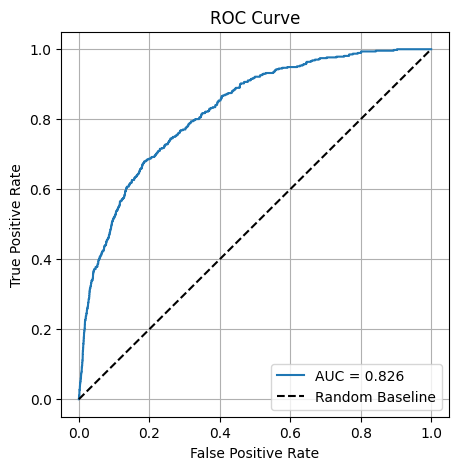

In [38]:
# ROC computation

function manual_roc(y, p)
    # Sort by predicted probability descending
    idx = sortperm(p, rev=true)
    y_sorted = y[idx]
    p_sorted = p[idx]

    # Total positive/negative counts
    P = sum(y_sorted .== 1)
    N = sum(y_sorted .== 0)

    # Initialize vectors
    tpr = Float64[]
    fpr = Float64[]

    tp = 0
    fp = 0

    # Iterate through sorted scores
    for i in 1:length(y_sorted)
        if y_sorted[i] == 1
            tp += 1
        else
            fp += 1
        end
        push!(tpr, tp / P)
        push!(fpr, fp / N)
    end

    return fpr, tpr
end

# --- Compute ROC ---
fpr, tpr = manual_roc(y, p)

# --- Compute AUC (trapezoidal rule) ---
function trapezoid(x, y)
    s = 0.0
    for i in 1:length(x)-1
        s += 0.5 * (y[i] + y[i+1]) * (x[i+1] - x[i])
    end
    return s
end

auc_value = trapezoid(fpr, tpr)
println("AUC = ", auc_value)

# --- Plot ROC ---
PyPlot.figure(figsize=(5,5))
PyPlot.plot(fpr, tpr, label="AUC = $(round(auc_value, digits=3))")
PyPlot.plot([0,1], [0,1], "k--", label="Random Baseline")
PyPlot.xlabel("False Positive Rate")
PyPlot.ylabel("True Positive Rate")
PyPlot.title("ROC Curve")
PyPlot.legend(loc="lower right")
PyPlot.grid(true)
PyPlot.show()


In [39]:
# y = true labels (0/1)
y = test_df.HighSeverity
p = pred_prob

# function to compute metrics for any threshold

function evaluate_threshold(y, p, τ)
    pred = ifelse.(p .>= τ, 1, 0)

    tp = sum((pred .== 1) .& (y .== 1))
    fp = sum((pred .== 1) .& (y .== 0))
    tn = sum((pred .== 0) .& (y .== 0))
    fn = sum((pred .== 0) .& (y .== 1))

    accuracy  = (tp + tn) / length(y)
    precision = tp == 0 ? 0.0 : tp / (tp + fp)
    recall    = tp == 0 ? 0.0 : tp / (tp + fn)
    f1        = (precision + recall) == 0 ? 0.0 : 2 * (precision * recall) / (precision + recall)

    return accuracy, precision, recall, f1
end

# test a grid of thresholds

thresholds = 0.01:0.01:0.9
metrics = Dict()

for τ in thresholds
    metrics[τ] = evaluate_threshold(y, p, τ)
end

# display thresholds and their associated metrics to make sure 0.5 is the best one to use

for (τ, (acc, prec, rec, f1)) in metrics
    println("τ=$(round(τ, digits=2))   ACC=$(round(acc, digits=3))  ",
            "PREC=$(round(prec, digits=3))  REC=$(round(rec, digits=3))  F1=$(round(f1, digits=3))")
end


τ=0.54   ACC=0.997  PREC=0.0  REC=0.0  F1=0.0
τ=0.86   ACC=0.997  PREC=0.0  REC=0.0  F1=0.0
τ=0.09   ACC=0.984  PREC=0.027  REC=0.143  F1=0.046
τ=0.35   ACC=0.997  PREC=0.0  REC=0.0  F1=0.0
τ=0.22   ACC=0.997  PREC=0.0  REC=0.0  F1=0.0
τ=0.38   ACC=0.997  PREC=0.0  REC=0.0  F1=0.0
τ=0.56   ACC=0.997  PREC=0.0  REC=0.0  F1=0.0
τ=0.2   ACC=0.997  PREC=0.0  REC=0.0  F1=0.0
τ=0.89   ACC=0.997  PREC=0.0  REC=0.0  F1=0.0
τ=0.06   ACC=0.966  PREC=0.012  REC=0.143  F1=0.022
τ=0.05   ACC=0.958  PREC=0.014  REC=0.214  F1=0.027
τ=0.48   ACC=0.997  PREC=0.0  REC=0.0  F1=0.0
τ=0.49   ACC=0.997  PREC=0.0  REC=0.0  F1=0.0
τ=0.57   ACC=0.997  PREC=0.0  REC=0.0  F1=0.0
τ=0.67   ACC=0.997  PREC=0.0  REC=0.0  F1=0.0
τ=0.71   ACC=0.997  PREC=0.0  REC=0.0  F1=0.0
τ=0.83   ACC=0.997  PREC=0.0  REC=0.0  F1=0.0
τ=0.24   ACC=0.997  PREC=0.0  REC=0.0  F1=0.0
τ=0.11   ACC=0.991  PREC=0.028  REC=0.071  F1=0.04
τ=0.3   ACC=0.997  PREC=0.0  REC=0.0  F1=0.0
τ=0.74   ACC=0.997  PREC=0.0  REC=0.0  F1=0.0
τ=0.08   ACC=

In [40]:
function evaluate_threshold(y, p, τ)
    pred = ifelse.(p .>= τ, 1, 0)

    tp = sum((pred .== 1) .& (y .== 1))
    fp = sum((pred .== 1) .& (y .== 0))
    tn = sum((pred .== 0) .& (y .== 0))
    fn = sum((pred .== 0) .& (y .== 1))

    accuracy  = (tp + tn) / length(y)
    precision = tp + fp == 0 ? NaN : tp / (tp + fp)
    recall    = tp + fn == 0 ? NaN : tp / (tp + fn)
    f1        = (isnan(precision) || isnan(recall) || precision+recall == 0) ? NaN : 2 * (precision*recall) / (precision + recall)

    println("\n=== Metrics at τ = $τ ===")
    println("Accuracy:  ", round(accuracy, digits=4))
    println("Precision: ", round(precision, digits=4))
    println("Recall:    ", round(recall, digits=4))
    println("F1 Score:  ", round(f1, digits=4))

    println("\nConfusion Matrix:")
    println("            Pred 0   Pred 1")
    println("True 0      $tn       $fp")
    println("True 1      $fn       $tp")

    return accuracy, precision, recall, f1
end

evaluate_threshold (generic function with 1 method)

In [43]:
evaluate_threshold(y, p, 0.03)


=== Metrics at τ = 0.03 ===
Accuracy:  0.93
Precision: 0.014
Recall:    0.3571
F1 Score:  0.0269

Confusion Matrix:
            Pred 0   Pred 1
True 0      4801       353
True 1      9       5


(0.929953560371517, 0.013966480446927373, 0.35714285714285715, 0.026881720430107527)

## Feature Importance Summary (Miami, nowcasting spec)

The model estimates the log-odds that an accident is High Severity using conditions known at (or proxying) report time. Effects are grouped by statistical significance, effect size, and plausibility.

### Most important predictors
Large, highly significant effects (p << 0.001) with clear interpretation.

1) Junction — +1.682 (z = 26.10, p < 1e-99)
   Incidents at junctions are much more likely to be severe.

2) Station — −1.974 (z = −10.63, p < 1e-25)
   Near stations, severity is lower—consistent with slower traffic.

3) Crossing — −0.859 (z = −8.87, p < 1e-18)
   Crosswalk areas associate with reduced severity.

4) Start_Lng — +0.435 (z = 8.90, p < 1e-18)
   Longitude acts as a stable geographic proxy for severity hotspots.

5) Traffic_Signal — +0.514 (z = 5.64, p < 1e-7)
   Signalized intersections correlate with higher severity.

6) Give_Way — +2.177 (z = 6.06, p < 1e-8)
   Rare but high-risk: yield contexts increase severity odds.

7) No_Exit — +1.040 (z = 5.15, p < 1e-6)
   Cul-de-sacs / dead-ends show higher severity risk.

### Weather and environment (significant, moderate effects)

- Humidity(%) — +0.107 (p = 0.0051)
- Pressure(in) — +0.087 (p = 0.0065)
- Precipitation(in) — +0.056 (p = 0.0093) → wet conditions increase risk.
- Weather_Condition__Cloudy_Windy — +1.824 (p = 0.0002)
- Weather_Condition__Heavy_Rain — +0.936 (p = 0.0036)
- Weather_Condition__Light_Rain — +0.301 (p = 0.0485)

Time-of-day proxies:
- Civil_Twilight__Night — +0.414 (p = 0.0367)
- Nautical_Twilight__Night — −0.599 (p = 0.0065)
- Astronomical_Twilight__Night — +0.471 (p = 0.0142)

### Day-of-week (relative to Monday)

- Tuesday — −0.234 (p = 0.010)
- Wednesday — −0.388 (p < 1e-4)
- Thursday — −0.237 (p = 0.0081)
- Saturday — −0.510 (p < 1e-4)
(Friday, Sunday are not significant.)

### Wind direction (small, proxy-like signals)

- NE — −0.353 (p = 0.035)
- NNE — −0.592 (p = 0.0077)
- NNW — −0.431 (p = 0.026)
Borderline: SE — −0.278 (p = 0.053). Others are non-significant.

### Location codes

- Airport_Code__KOPF — −0.715 (p = 0.045)
- Airport_Code__KTMB — −0.815 (p = 0.0022)
(KMIA/KHWO are non-significant in this spec.)

### Not important (drop/penalize hard)

High p-values, huge SEs, or ultra-sparse:

- Most wind direction and weather dummies not listed above
- Turning_Loop (aliased/constant → NaN SE)
- Temperature(F), Wind_Chill(F) (non-significant here)
- Start_Lat (non-significant here)

### Notes on leakage and hygiene

- Spec avoids obvious leakage (no End_*, Distance(mi), DurationMinutes).
- Ensure one-hot categories/levels were learned on train and applied to test.
- Prefer regularization (L1/L2) to stabilize rare categories and reduce variance.

### Notes on threshold

- lower threshold improves recall-- best closest to 0, but we compromise on accuracy as a result.

# Sparse Logistic Regression

We fit a **sparse logistic regression** model with an L1 penalty.

Let:

- $x_i \in \mathbb{R}^d$ be the feature vector for sample $i = 1, \dots, n$
- $y_i \in \{0, 1\}$ be the label for sample $i$
- $w \in \mathbb{R}^d$ be the weight vector
- $b \in \mathbb{R}$ be the intercept
- $\sigma(t) = \dfrac{1}{1 + e^{-t}}$ be the logistic sigmoid

The model is

$$
p(y_i = 1 \mid x_i) = \sigma(w^\top x_i + b).
$$

The **negative log-likelihood** (logistic loss) for a single sample is

$$
\ell_i(w,b) 
= -\Big[ y_i \log(\sigma(w^\top x_i + b)) 
+ (1 - y_i)\log\big(1 - \sigma(w^\top x_i + b)\big) \Big].
$$

We add an L1 penalty on the weights to induce sparsity:

$$
\lambda \lVert w \rVert_1 
= \lambda \sum_{j=1}^d \lvert w_j \rvert,
$$

where $\lambda \ge 0$ controls the strength of regularization.

The full sparse logistic regression problem is

$$
\min_{w \in \mathbb{R}^d,\; b \in \mathbb{R}}
\left\{
\frac{1}{n} \sum_{i=1}^n 
\Big(
- y_i \log(\sigma(w^\top x_i + b)) 
- (1 - y_i)\log\big(1 - \sigma(w^\top x_i + b)\big)
\Big)
+
\lambda \lVert w \rVert_1
\right\}.
$$

Equivalently, if we encode labels as $y_i \in \{-1, +1\}$, we can write the loss as

$$
\ell_i(w,b) 
= \log\big(1 + \exp(-y_i (w^\top x_i + b))\big),
$$

and the optimization problem becomes

$$
\min_{w \in \mathbb{R}^d,\; b \in \mathbb{R}}
\left\{
\frac{1}{n} \sum_{i=1}^n 
\log\big(1 + \exp(-y_i (w^\top x_i + b))\big)
+
\lambda \lVert w \rVert_1
\right\}.
$$


In [21]:
using CSV, DataFrames
using MLJ
using MLJLinearModels
using Random
using Statistics 

# Load data
train_df = CSV.read("train_df.csv", DataFrame)   
test_df  = CSV.read("test_df.csv", DataFrame)

target = :HighSeverity_int

# Predictor list
predictors = ["Start_Lat", "Start_Lng", "Temperature(F)", "Wind_Chill(F)", 
    "Humidity(%)", "Pressure(in)", "Visibility(mi)", "Wind_Speed(mph)", "Precipitation(in)", "Amenity", "Bump", "Crossing", 
    "Give_Way", "Junction", "No_Exit", "Railway", "Roundabout", "Station", "Stop", "Traffic_Calming", "Traffic_Signal", "Turning_Loop", 
    "DayOfWeek__Tuesday", "DayOfWeek__Wednesday", "DayOfWeek__Thursday", "DayOfWeek__Friday", "DayOfWeek__Saturday", 
    "DayOfWeek__Sunday", "Airport_Code__KHWO", "Airport_Code__KMIA", "Airport_Code__KOPF", "Airport_Code__KTMB", "Wind_Direction__E", "Wind_Direction__ENE", 
    "Wind_Direction__ESE", "Wind_Direction__N", "Wind_Direction__NE", "Wind_Direction__NNE", "Wind_Direction__NNW", "Wind_Direction__NW", "Wind_Direction__S", 
    "Wind_Direction__SE", "Wind_Direction__SSE", "Wind_Direction__SSW", "Wind_Direction__SW", "Wind_Direction__VAR", "Wind_Direction__W", "Wind_Direction__WNW", 
    "Wind_Direction__WSW", "Weather_Condition__Cloudy_Windy", "Weather_Condition__Fair", "Weather_Condition__Fair_Windy", "Weather_Condition__Fog", 
    "Weather_Condition__Haze", "Weather_Condition__Heavy_Rain", "Weather_Condition__Heavy_Rain_Windy", "Weather_Condition__Heavy_T_Storm", 
    "Weather_Condition__Heavy_T_Storm_Windy", "Weather_Condition__Light_Drizzle", "Weather_Condition__Light_Rain", "Weather_Condition__Light_Rain_Windy", 
    "Weather_Condition__Light_Rain_with_Thunder", "Weather_Condition__Mostly_Cloudy", "Weather_Condition__Mostly_Cloudy_Windy", "Weather_Condition__Partly_Cloudy", 
    "Weather_Condition__Partly_Cloudy_Windy", "Weather_Condition__Rain", "Weather_Condition__Rain_Windy", "Weather_Condition__Shallow_Fog", "Weather_Condition__Smoke", 
    "Weather_Condition__Squalls_Windy", "Weather_Condition__T_Storm", "Weather_Condition__T_Storm_Windy", "Weather_Condition__Thunder", "Weather_Condition__Thunder_Windy", 
    "Weather_Condition__Thunder_in_the_Vicinity", "Sunrise_Sunset__Night", "Civil_Twilight__Night", "Nautical_Twilight__Night", "Astronomical_Twilight__Night"]

# convert to Symbols to match DataFrame column names
predictor_syms = Symbol.(predictors)

# Build X/y with ONLY these predictors
y_train_raw = train_df[!, target]
y_test_raw  = test_df[!, target]

X_train_raw = select(train_df, predictor_syms)
X_test_raw  = select(test_df, predictor_syms)

# Targets as Multiclass
y_train = coerce(y_train_raw, Multiclass)
y_test  = coerce(y_test_raw, Multiclass)

# Features: make them Continuous (floats) using training schema, then apply same schema to test set
X_train_autotypes = autotype(X_train_raw, rules = (:discrete_to_continuous,))
X_train = coerce(X_train_raw, X_train_autotypes)
X_test  = coerce(X_test_raw,  X_train_autotypes)

5168×80 DataFrame
  Row │ Start_Lat   Start_Lng  Temperature(F)  Wind_Chill(F)  Humidity(%)  Pre ⋯
      │ Float64     Float64    Float64         Float64        Float64      Flo ⋯
──────┼─────────────────────────────────────────────────────────────────────────
    1 │  0.763759    1.17934       -0.509481      -0.50656    -0.357412        ⋯
    2 │  1.91545     1.67351        0.438686       0.437804   -1.55429
    3 │  0.142714    1.1405         0.709591       0.707622   -0.568625
    4 │ -0.0701346   1.26828       -1.05129       -1.0462      1.05068
    5 │  1.55264     1.18614       -1.72855       -1.72074     1.4731          ⋯
    6 │  0.0919299   1.27327       -0.374029      -0.371651    0.13542
    7 │  1.92398     1.67966       -1.3222        -1.31601     1.26189
    8 │  0.147999    1.15351        0.980496       0.97744    -0.850243
    9 │  1.61922     1.24642       -1.72855       -1.72074     1.4731          ⋯
   10 │  0.386738    1.27353       -2.54127       -2.5302      1.89553
   11 │  2.01103     1.67716        0.438686       0.437804   -1.55429
  ⋮   │     ⋮           ⋮            ⋮               ⋮             ⋮           ⋱
 5159 │  1.68658     1.37765        0.0323288      0.0330763  -0.216603
 5160 │  0.513854    0.809772      -0.238576      -0.236742    0.698656      - ⋯
 5161 │  0.0974369  -0.357229      -0.509481      -0.50656    -0.357412
 5162 │ -0.116067   -1.02399       -2.27036       -2.26038     1.19149
 5163 │ -0.65024     0.251858      -2.81217       -2.80001    -1.55429
 5164 │ -0.928366   -0.976678      -0.780386      -0.776378    0.698656        ⋯
 5165 │ -1.01588    -0.732812      -1.86401       -1.85565     2.17715
 5166 │ -1.01717    -0.782283      -1.18674       -1.18111     0.487442
 5167 │  1.229       1.48026        0.438686       0.437804   -0.639029
 5168 │  0.887536    0.76897        0.0323288      0.0330763  -1.20227         ⋯
                                                75 columns and 5147 rows omitted

In [22]:
# Inner Train/Validation split for lambda tuning
logit = @load LogisticClassifier pkg = MLJLinearModels verbosity = 0

Random.seed!(456)  # seed for inner split
inner_train_inds, val_inds = partition(eachindex(y_train), 0.8, shuffle=true)

X_tr2 = X_train[inner_train_inds, :]
y_tr2 = y_train[inner_train_inds]
X_val = X_train[val_inds, :]
y_val = y_train[val_inds]

27469-element CategoricalArrays.CategoricalArray{Int64,1,UInt32}:
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 ⋮
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0

In [23]:
# Lambda tuning (L1 sparse logistic)
lambda_grid = [1e-4, 1e-3, 1e-2, 1e-1, 1.0, 10.0]

best_lambda = nothing
best_val_acc = -Inf

println("Tuning lambda...")
for λ in lambda_grid
    model = logit(
        penalty = :l1,
        lambda = λ,
        fit_intercept = true,
    )

    mach_tmp = machine(model, X_tr2, y_tr2)
    fit!(mach_tmp)

    yhat_val = predict_mode(mach_tmp, X_val)
    val_acc = mean(yhat_val .== y_val)

    println("  λ = ", λ, "  validation accuracy = ", val_acc)

    if val_acc > best_val_acc
        best_val_acc = val_acc
        best_lambda = λ
    end
end

println("\nBest λ = ", best_lambda, " with validation accuracy = ", best_val_acc)

Tuning lambda...


[ Info: Training machine(LogisticClassifier(lambda = 0.0001, …), …).
┌ Info: Solver: ProxGrad
│   accel: Bool true
│   max_iter: Int64 1000
│   tol: Float64 0.0001
│   max_inner: Int64 100
│   beta: Float64 0.8
└   gram: Bool false
┌ Warning: Proximal GD did not converge in 1000 iterations.
└ @ MLJLinearModels ~/.julia/packages/MLJLinearModels/s9vSj/src/fit/proxgrad.jl:73


  λ = 0.0001  validation accuracy = 0.9884961229021806
  λ = 0.001

[ Info: Training machine(LogisticClassifier(lambda = 0.001, …), …).
┌ Info: Solver: ProxGrad
│   accel: Bool true
│   max_iter: Int64 1000
│   tol: Float64 0.0001
│   max_inner: Int64 100
│   beta: Float64 0.8
└   gram: Bool false


  validation accuracy = 0.9884961229021806
  λ = 0.01

[ Info: Training machine(LogisticClassifier(lambda = 0.01, …), …).
┌ Info: Solver: ProxGrad
│   accel: Bool true
│   max_iter: Int64 1000
│   tol: Float64 0.0001
│   max_inner: Int64 100
│   beta: Float64 0.8
└   gram: Bool false


  validation accuracy = 0.9884961229021806


[ Info: Training machine(LogisticClassifier(lambda = 0.1, …), …).
┌ Info: Solver: ProxGrad
│   accel: Bool true
│   max_iter: Int64 1000
│   tol: Float64 0.0001
│   max_inner: Int64 100
│   beta: Float64 0.8
└   gram: Bool false


  λ = 0.1  validation accuracy = 0.9884961229021806
  λ = 1.0

[ Info: Training machine(LogisticClassifier(lambda = 1.0, …), …).
┌ Info: Solver: ProxGrad
│   accel: Bool true
│   max_iter: Int64 1000
│   tol: Float64 0.0001
│   max_inner: Int64 100
│   beta: Float64 0.8
└   gram: Bool false


  validation accuracy = 0.9884961229021806
  λ = 10.0

[ Info: Training machine(LogisticClassifier(lambda = 10.0, …), …).
┌ Info: Solver: ProxGrad
│   accel: Bool true
│   max_iter: Int64 1000
│   tol: Float64 0.0001
│   max_inner: Int64 100
│   beta: Float64 0.8
└   gram: Bool false


  validation accuracy = 0.9884961229021806

Best λ = 0.0001 with validation accuracy = 0.9884961229021806


In [24]:
# Fit final sparse model on full training set
sparse_logit = logit(
    penalty = :l1,
    lambda = best_lambda,
    fit_intercept = true
)

mach = machine(sparse_logit, X_train, y_train)
fit!(mach)

[ Info: Training machine(LogisticClassifier(lambda = 0.0001, …), …).
┌ Info: Solver: ProxGrad
│   accel: Bool true
│   max_iter: Int64 1000
│   tol: Float64 0.0001
│   max_inner: Int64 100
│   beta: Float64 0.8
└   gram: Bool false
┌ Warning: Proximal GD did not converge in 1000 iterations.
└ @ MLJLinearModels ~/.julia/packages/MLJLinearModels/s9vSj/src/fit/proxgrad.jl:73


trained Machine; caches model-specific representations of data
  model: LogisticClassifier(lambda = 0.0001, …)
  args: 
    1:	Source @764 ⏎ Table{AbstractVector{Continuous}}
    2:	Source @956 ⏎ AbstractVector{Multiclass{2}}


In [25]:
# Inspect fitted parameters
fp = fitted_params(mach)

coefs_pairs = fp.coefs              
intercept   = fp.intercept

# Split pairs into feature names and numeric weights
features = Symbol.(first.(coefs_pairs))
weights  = Float64.(last.(coefs_pairs))

# Coefficient table
coef_table = DataFrame(
    feature = features,
    coef    = weights
)

# Non-zero (selected) features
tol = 1e-6  
nonzero = coef_table[abs.(coef_table.coef) .> tol, :]

println("\nNonzero (selected) features:")
show(nonzero, allrows=true, allcols=true)

# Rank all features by importance (|coef| size)
coef_table.abs_coef = abs.(coef_table.coef)
sort!(coef_table, :abs_coef, rev=true)

println("\nTop 20 most important features (by |coef|):")
top20 = first(coef_table, min(20, nrow(coef_table)))
show(top20, allrows=true, allcols=true)

println("\nIntercept (bias term): ", intercept)


Nonzero (selected) features:
32×2 DataFrame
 Row │ feature                       coef
     │ Symbol                        Float64
─────┼───────────────────────────────────────────
   1 │ Start_Lng                      0.427132
   2 │ Temperature(F)                 0.232712
   3 │ Humidity(%)                    0.105167
   4 │ Pressure(in)                   0.0438902
   5 │ Visibility(mi)                -0.0392894
   6 │ Wind_Speed(mph)               -0.0529791
   7 │ Precipitation(in)              0.0458687
   8 │ Crossing                      -0.766607
   9 │ Junction                       1.65368
  10 │ No_Exit                        0.236365
  11 │ Station                       -1.61913
  12 │ Stop                          -0.529712
  13 │ Traffic_Signal                 0.417348
  14 │ DayOfWeek__Tuesday            -0.0402081
  15 │ DayOfWeek__Wednesday          -0.180978
  16 │ DayOfWeek__Thursday           -0.0306389
  17 │ DayOfWeek__Saturday           -0.235427
  18 │ DayOfWee

In [26]:
# Evaluate on test set from test_df
yhat = predict_mode(mach, X_test)   # predicted class labels
acc = mean(yhat .== y_test)
println("\nTest accuracy with tuned λ = ", best_lambda, ": ", acc)


Test accuracy with tuned λ = 0.0001: 0.9972910216718266


In [27]:
CSV.write("nonzero_selected_features.csv", nonzero)

"nonzero_selected_features.csv"

# Sparse OCTs

## OCT on Accuracy

In [48]:
# Get selected (non-zero) features from sparse logistic
tol = 1e-6
nonzero = coef_table[abs.(coef_table.coef) .> tol, :]

selected_features = Symbol.(nonzero.feature)

println("Using ", length(selected_features), " non-zero features.")

Using 32 non-zero features.


In [49]:
# Subset X_train and X_test to selected features only
X_train_oct = select(X_train, selected_features)
X_test_oct  = select(X_test,  selected_features)

# Labels for OCT: use original integer/binary targets from train_df/test_df
y_train_oct = collect(y_train_raw)   
y_test_oct  = collect(y_test_raw)

println("Size of OCT training set: ", size(X_train_oct), ", labels length: ", length(y_train_oct))
println("Size of OCT test set: ", size(X_test_oct), ", labels length: ", length(y_test_oct))

Size of OCT training set: (137343, 32), labels length: 137343
Size of OCT test set: (5168, 32), labels length: 5168


In [50]:
# Train an OCT with grid search + 5-fold CV on training data
seed = 42
max_depths = [3, 5, 7, 9]
minbuckets = [50, 100, 200, 500]
criterion = "gini"

grid_search = IAI.GridSearch(
    IAI.OptimalTreeClassifier(
        random_seed = seed,
        criterion = criterion,
    ),
    max_depth = max_depths,
    minbucket = minbuckets,
)

# Perform k-fold cross-validation on the training set only
IAI.fit_cv!(
    grid_search,
    X_train_oct,
    y_train_oct,
    validation_criterion = :auc,
    n_folds = 5,
)

# Get best model and hyperparameters
best_model = IAI.get_learner(grid_search)
println("Best OCT hyperparameters:")
println("  Max depth: ", best_model.max_depth)
println("  Minbucket: ", best_model.minbucket)
println("  Criterion: ", best_model.criterion)

# Evaluate on training set
train_auc = IAI.score(
    best_model, X_train_oct, y_train_oct;
    criterion = :auc,
    positive_label = 1,  
)

train_acc = IAI.score(
    best_model, X_train_oct, y_train_oct;
    criterion = :accuracy,
    positive_label = 1,
)

y_pred_train = IAI.predict(best_model, X_train_oct)
y_prob_train = IAI.predict_proba(best_model, X_train_oct)

println("Training AUC score: ", round(train_auc, digits=4))
println("Training Accuracy:  ", round(train_acc, digits=4))

# Evaluate on test set
test_auc = IAI.score(
    best_model, X_test_oct, y_test_oct;
    criterion = :auc,
    positive_label = 1,
)

test_acc = IAI.score(
    best_model, X_test_oct, y_test_oct;
    criterion = :accuracy,
    positive_label = 1,
)

y_pred_test = IAI.predict(best_model, X_test_oct)
y_prob_test = IAI.predict_proba(best_model, X_test_oct)

println("Test AUC score: ", round(test_auc, digits=4))
println("Test Accuracy:  ", round(test_acc, digits=4))

[ Warning: This copy of Interpretable AI software is for academic purposes only and not for commercial use.


Best OCT hyperparameters:
  Max depth: 9
  Minbucket: 500
  Criterion: gini
Training AUC score: 0.8842
Training Accuracy:  0.9887
Test AUC score: 0.712
Test Accuracy:  0.9973


In [51]:
best_model

Fitted OptimalTreeClassifier:
  1) Split: Junction < 0.5
    2) Split: Start_Lng < 0.8019
      3) Split: Humidity(%) < 0.5226
        4) Split: Start_Lng < -0.1804
          5) Split: Stop < 0.5
            6) Split: Start_Lng < -0.9254
              7) Split: Start_Lng < -1.962
                8) Predict: 0 (98.61%), [497,7], 504 points, error 0.02739
                9) Split: Start_Lng < -0.9437
                  10) Predict: 0 (99.92%), [15765,12], 15777 points, error 0.00152
                  11) Predict: 0 (97.24%), [669,19], 688 points, error 0.05371
              12) Split: Start_Lng < -0.7819
                13) Split: Start_Lng < -0.8189
                  14) Predict: 0 (99.91%), [5713,5], 5718 points, error 0.001747
                  15) Predict: 0 (98.00%), [490,10], 500 points, error 0.0392
                16) Split: Start_Lng < -0.7209
                  17) Split: Airport_Code__KMIA < 0.5
                    18) Predict: 0 (97.81%), [491,11], 502 points, error 0.04286
                    19) Predict: 0 (99.89%), [2766,3], 2769 points, error 0.002164
                  20) Split: Start_Lng < -0.2001
                    21) Predict: 0 (99.80%), [17252,35], 17287 points, error 0.004041
                    22) Predict: 0 (98.54%), [609,9], 618 points, error 0.0287
            23) Predict: 0 (100.00%), [4259,0], 4259 points, error 0
          24) Split: Humidity(%) < -0.6742
            25) Split: Start_Lng < -0.1604
              26) Predict: 0 (91.60%), [480,44], 524 points, error 0.1538
              27) Split: Airport_Code__KMIA < 0.5
                28) Predict: 0 (100.00%), [2257,0], 2257 points, error 0
                29) Split: Start_Lng < 0.2166
                  30) Split: Start_Lng < -0.123
                    31) Predict: 0 (98.80%), [494,6], 500 points, error 0.02371
                    32) Predict: 0 (99.83%), [2398,4], 2402 points, error 0.003325
                  33) Predict: 0 (99.00%), [1385,14], 1399 points, error 0.01981
            34) Split: Start_Lng < -0.1396
              35) Split: Wind_Speed(mph) < -0.1739
                36) Predict: 0 (95.60%), [522,24], 546 points, error 0.08405
                37) Predict: 0 (98.95%), [846,9], 855 points, error 0.02083
              38) Split: Start_Lng < 0.6563
                39) Split: Wind_Speed(mph) < 0.8261
                  40) Predict: 0 (99.74%), [5312,14], 5326 points, error 0.005243
                  41) Split: Wind_Speed(mph) < 1.026
                    42) Predict: 0 (97.81%), [491,11], 502 points, error 0.04286
                    43) Predict: 0 (99.51%), [1215,6], 1221 points, error 0.00978
                44) Predict: 0 (99.77%), [3449,8], 3457 points, error 0.004618
        45) Split: Pressure(in) < -0.8213
          46) Split: DayOfWeek__Wednesday < 0.5
            47) Split: Start_Lng < -0.2118
              48) Split: Visibility(mi) < -2.484
                49) Predict: 0 (97.86%), [503,11], 514 points, error 0.04189
                50) Split: Astronomical_Twilight__Night < 0.5
                  51) Split: Wind_Speed(mph) < -1.074
                    52) Predict: 0 (99.10%), [767,7], 774 points, error 0.01792
                    53) Predict: 0 (99.85%), [2014,3], 2017 points, error 0.00297
                  54) Predict: 0 (98.67%), [892,12], 904 points, error 0.0262
              55) Split: Start_Lng < -0.08702
                56) Predict: 0 (94.05%), [474,30], 504 points, error 0.112
                57) Predict: 0 (99.34%), [907,6], 913 points, error 0.01306
            58) Predict: 0 (99.75%), [1195,3], 1198 points, error 0.004996
          59) Split: DayOfWeek__Wednesday < 0.5
            60) Split: Start_Lng < -0.1237
              61) Split: Humidity(%) < 1.438
                62) Split: Start_Lng < -0.2
                  63) Split: Start_Lng < -0.9787
                    64) Predict: 0 (99.94%), [3164,2], 3166 points, error 0.001263
                    65) Predict: 0 (99.07%), [5314,50], 5364 points, error 0.01847
              

In [52]:
tp_test = sum((y_test_oct .== 1) .& (y_pred_test .== 1))
fn_test = sum((y_test_oct .== 1) .& (y_pred_test .== 0))

test_recall_manual = tp_test / (tp_test + fn_test)
println("Test Recall (Sensitivity): ", round(test_recall_manual, digits=4))

tp_train = sum((y_train_oct .== 1) .& (y_pred_train .== 1))
fn_train = sum((y_train_oct .== 1) .& (y_pred_train .== 0))

train_recall_manual = tp_train / (tp_train + fn_train)
println("Training Recall (Sensitivity): ", round(train_recall_manual, digits=4))

Test Recall (Sensitivity): 0.0
Training Recall (Sensitivity): 0.0


In [53]:
# Take P(y=1) from train and test for the base OCT
prob_train = y_prob_train[:, 2]
prob_test  = y_prob_test[:, 2]

# Train on top, test 2023 on bottom
prob_all = vcat(prob_train, prob_test)

prob_df = DataFrame(
    prob_class1 = prob_all,
)

CSV.write("sparseyhat.csv", prob_df)

"sparseyhat.csv"

## OCT Recall

In [54]:
# Realizing not to use accuracy maybe because of the class imbalance, trying autobalance and recall
# https://docs.interpretable.ai/stable/OptimalTrees/tips/
# Train an OCT with grid search + 5-fold CV on training data
seed = 42
max_depths = [3, 5, 7, 9]
minbuckets = [50, 100, 200, 500]
criterion = "gini"

grid_search = IAI.GridSearch(
    IAI.OptimalTreeClassifier(
        random_seed = seed,
        criterion   = criterion,
        show_progress = false,   
    ),
    max_depth = max_depths,
    minbucket = minbuckets,
)

IAI.fit_cv!(
    grid_search,
    X_train_oct,
    y_train_oct;
    validation_criterion = :sensitivity,   # choose HPs by recall
    positive_label       = 1,              # HighSeverity = 1
    sample_weight        = :autobalance,   # balance the classes
    n_folds              = 5,
    verbose              = true,           # progress, prints each combo’s score
)

# Get best model and hyperparameters
best_model_octrecall = IAI.get_learner(grid_search)
println("Best OCT hyperparameters:")
println("  Max depth: ", best_model_octrecall.max_depth)
println("  Minbucket: ", best_model_octrecall.minbucket)
println("  Criterion: ", best_model_octrecall.criterion)

# Evaluate on training set
train_auc = IAI.score(
    best_model_octrecall, X_train_oct, y_train_oct;
    criterion      = :auc,
    positive_label = 1,
)

train_acc = IAI.score(
    best_model_octrecall, X_train_oct, y_train_oct;
    criterion      = :accuracy,
    positive_label = 1,
)

train_recall = IAI.score(
    best_model_octrecall, X_train_oct, y_train_oct;
    criterion      = :sensitivity,
    positive_label = 1,
)

println("Training AUC:     ", round(train_auc, digits=4))
println("Training Accuracy:", round(train_acc, digits=4))
println("Training Recall:  ", round(train_recall, digits=4))

# Evaluate on test set
test_auc = IAI.score(
    best_model_octrecall, X_test_oct, y_test_oct;
    criterion      = :auc,
    positive_label = 1,
)

test_acc = IAI.score(
    best_model_octrecall, X_test_oct, y_test_oct;
    criterion      = :accuracy,
    positive_label = 1,
)

test_recall = IAI.score(
    best_model_octrecall, X_test_oct, y_test_oct;
    criterion      = :sensitivity,
    positive_label = 1,
)

println("Test AUC:         ", round(test_auc, digits=4))
println("Test Accuracy:    ", round(test_acc, digits=4))
println("Test Recall:      ", round(test_recall, digits=4))

y_pred_train2 = IAI.predict(best_model_octrecall, X_train_oct)
y_pred_test2  = IAI.predict(best_model_octrecall, X_test_oct)
y_prob_train2 = IAI.predict_proba(best_model_octrecall, X_train_oct)
y_prob_test2  = IAI.predict_proba(best_model_octrecall, X_test_oct)

fold 1; train: 0.2989; valid: 1; cp=>0.5686 minbucket=>50 max_depth=>3
fold 1; train: 0.2989; valid: 1; cp=>0.5685 minbucket=>100 max_depth=>3
fold 1; train: 0.2989; valid: 1; cp=>0.5686 minbucket=>200 max_depth=>3
fold 1; train: 0.2986; valid: 1; cp=>0.5686 minbucket=>500 max_depth=>3
fold 1; train: 0.4125; valid: 1; cp=>0.5685 minbucket=>50 max_depth=>5
fold 1; train: 0.4151; valid: 1; cp=>0.5685 minbucket=>100 max_depth=>5
fold 1; train: 0.4022; valid: 1; cp=>0.5686 minbucket=>200 max_depth=>5
fold 1; train: 0.3978; valid: 1; cp=>0.5685 minbucket=>500 max_depth=>5
fold 1; train: 0.4957; valid: 1; cp=>0.5592 minbucket=>50 max_depth=>7
fold 1; train: 0.4911; valid: 1; cp=>0.5686 minbucket=>100 max_depth=>7
fold 1; train: 0.4851; valid: 1; cp=>0.5672 minbucket=>200 max_depth=>7
fold 1; train: 0.4586; valid: 1; cp=>0.5686 minbucket=>500 max_depth=>7
fold 1; train: 0.5759; valid: 1; cp=>0.5686 minbucket=>50 max_depth=>9
fold 1; train: 0.561; valid: 1; cp=>0.5686 minbucket=>100 max_depth=

5168×2 DataFrame
  Row │ 0        1
      │ Float64  Float64
──────┼──────────────────
    1 │     0.5      0.5
    2 │     0.5      0.5
    3 │     0.5      0.5
    4 │     0.5      0.5
    5 │     0.5      0.5
    6 │     0.5      0.5
    7 │     0.5      0.5
    8 │     0.5      0.5
    9 │     0.5      0.5
   10 │     0.5      0.5
   11 │     0.5      0.5
  ⋮   │    ⋮        ⋮
 5159 │     0.5      0.5
 5160 │     0.5      0.5
 5161 │     0.5      0.5
 5162 │     0.5      0.5
 5163 │     0.5      0.5
 5164 │     0.5      0.5
 5165 │     0.5      0.5
 5166 │     0.5      0.5
 5167 │     0.5      0.5
 5168 │     0.5      0.5
        5147 rows omitted

In [55]:
best_model_octrecall

Fitted OptimalTreeClassifier:
  1) Predict: 0 (98.87%), [135787,1556], 137343 points, error 0.5

In [56]:
tp_test2 = sum((y_test_oct .== 1) .& (y_pred_test2 .== 1))
fn_test2 = sum((y_test_oct .== 1) .& (y_pred_test2 .== 0))

test_recall_manual2 = tp_test2 / (tp_test2 + fn_test2)
println("Test Recall (Sensitivity): ", round(test_recall_manual2, digits=4))

tp_train2 = sum((y_train_oct .== 1) .& (y_pred_train2 .== 1))
fn_train2 = sum((y_train_oct .== 1) .& (y_pred_train2 .== 0))

train_recall_manual2 = tp_train2 / (tp_train2 + fn_train2)
println("Training Recall (Sensitivity): ", round(train_recall_manual2, digits=4))

Test Recall (Sensitivity): 0.0
Training Recall (Sensitivity): 0.0


In [57]:
# Take P(y=1) from train and test for OCT (recall-tuned)
prob_train2 = y_prob_train2[:, 2]
prob_test2  = y_prob_test2[:, 2]

# Train on top, test 2023 on bottom
prob_all2 = vcat(prob_train2, prob_test2)

prob_df2 = DataFrame(
    prob_class1 = prob_all2,
)

CSV.write("sparseyhat_octrecall.csv", prob_df2)

"sparseyhat_octrecall.csv"

# OCT-H

In [16]:
# Subset X_train and X_test to selected features only
X_train_oct_h = select(X_train, selected_features)
X_test_oct_h  = select(X_test,  selected_features)

# Labels: use original binary/int targets from train_df / test_df
y_train_oct_h = collect(y_train_raw)
y_test_oct_h  = collect(y_test_raw)

# Hyperplane Optimal Classification Tree (OCT-H)
seed = 42
max_depths   = [3, 5]
minbuckets   = [100, 200]
criterion    = "gini"

# Enable progress logging BEFORE fitting

grid_search_oct_h = IAI.GridSearch(
    IAI.OptimalTreeClassifier(
        random_seed       = seed,
        criterion         = criterion,
        hyperplane_config = (sparsity = 3,),   # OCT-H
        fast_num_support_restarts = 10,
        ls_ignore_errors  = true,                 
    ),
    max_depth = max_depths,
    minbucket = minbuckets,
)

println("=== Running OCT-H Grid Search ===")
@time IAI.fit_cv!(
    grid_search_oct_h,
    X_train_oct_h,
    y_train_oct_h;
    validation_criterion = :sensitivity,
    positive_label       = 1,
    sample_weight        = :autobalance,
    n_folds              = 2,
    verbose = true,
)
println("=== Grid Search Complete ===")

# Get best OCT-H model and hyperparameters
best_model_oct_h = IAI.get_learner(grid_search_oct_h)
println("Best OCT-H hyperparameters:")
println("  Max depth: ", best_model_oct_h.max_depth)
println("  Minbucket: ", best_model_oct_h.minbucket)
println("  Criterion: ", best_model_oct_h.criterion)

# Training metrics
train_auc_oct_h = IAI.score(best_model_oct_h, X_train_oct_h, y_train_oct_h;
    criterion = :auc, positive_label = 1)

train_acc_oct_h = IAI.score(best_model_oct_h, X_train_oct_h, y_train_oct_h;
    criterion = :accuracy, positive_label = 1)

train_recall_oct_h = IAI.score(best_model_oct_h, X_train_oct_h, y_train_oct_h;
    criterion = :sensitivity, positive_label = 1)

println("OCT-H Training AUC:     ", round(train_auc_oct_h, digits=4))
println("OCT-H Training Accuracy:", round(train_acc_oct_h, digits=4))
println("OCT-H Training Recall:  ", round(train_recall_oct_h, digits=4))

# Test metrics
test_auc_oct_h = IAI.score(best_model_oct_h, X_test_oct_h, y_test_oct_h;
    criterion = :auc, positive_label = 1)

test_acc_oct_h = IAI.score(best_model_oct_h, X_test_oct_h, y_test_oct_h;
    criterion = :accuracy, positive_label = 1)

test_recall_oct_h = IAI.score(best_model_oct_h, X_test_oct_h, y_test_oct_h;
    criterion = :sensitivity, positive_label = 1)

println("OCT-H Test AUC:         ", round(test_auc_oct_h, digits=4))
println("OCT-H Test Accuracy:    ", round(test_acc_oct_h, digits=4))
println("OCT-H Test Recall:      ", round(test_recall_oct_h, digits=4))

# Predictions / probabilities
y_pred_train_oct_h = IAI.predict(best_model_oct_h, X_train_oct_h)
y_pred_test_oct_h  = IAI.predict(best_model_oct_h, X_test_oct_h)

y_prob_train_oct_h = IAI.predict_proba(best_model_oct_h, X_train_oct_h)
y_prob_test_oct_h  = IAI.predict_proba(best_model_oct_h, X_test_oct_h)

=== Running OCT-H Grid Search ===
fold 1; train: 0.388; valid: 1; cp=>0.5649 minbucket=>100 max_depth=>3
fold 1; train: 0.3857; valid: 1; cp=>0.5649 minbucket=>200 max_depth=>3
fold 1; train: 0.509; valid: 1; cp=>0.5649 minbucket=>100 max_depth=>5
fold 1; train: 0.5056; valid: 1; cp=>0.5649 minbucket=>200 max_depth=>5
fold 2; train: 0.3744; valid: 0.8086; cp=>0.0537 minbucket=>100 max_depth=>3
fold 2; train: 0.3846; valid: 0.7986; cp=>0.05169 minbucket=>200 max_depth=>3
fold 2; train: 0.5045; valid: 0.7915; cp=>0.003766 minbucket=>100 max_depth=>5
fold 2; train: 0.5046; valid: 0.7744; cp=>0.02971 minbucket=>200 max_depth=>5
25051.755790 seconds (28.53 G allocations: 2.100 TiB, 0.55% gc time, 0.02% compilation time: 5% of which was recompilation)
=== Grid Search Complete ===
Best OCT-H hyperparameters:
  Max depth: 3
  Minbucket: 100
  Criterion: gini
OCT-H Training AUC:     0.8325
OCT-H Training Accuracy:0.7731
OCT-H Training Recall:  0.8001
OCT-H Test AUC:         0.7199
OCT-H Test Ac

5168×2 DataFrame
  Row │ 0         1
      │ Float64   Float64
──────┼────────────────────
    1 │ 0.28045   0.71955
    2 │ 0.28045   0.71955
    3 │ 0.28045   0.71955
    4 │ 0.28045   0.71955
    5 │ 0.108857  0.891143
    6 │ 0.28045   0.71955
    7 │ 0.28045   0.71955
    8 │ 0.28045   0.71955
    9 │ 0.28045   0.71955
   10 │ 0.108857  0.891143
   11 │ 0.28045   0.71955
  ⋮   │    ⋮         ⋮
 5159 │ 0.28045   0.71955
 5160 │ 0.880135  0.119865
 5161 │ 0.880135  0.119865
 5162 │ 0.897576  0.102424
 5163 │ 0.811353  0.188647
 5164 │ 0.627367  0.372633
 5165 │ 0.627367  0.372633
 5166 │ 0.880135  0.119865
 5167 │ 0.799202  0.200798
 5168 │ 0.880135  0.119865
          5147 rows omitted

In [17]:
best_model_oct_h

Fitted OptimalTreeClassifier:
  1) Split: -0.004132 * Junction - 1.01 * Station + 0.002225 * Start_Lng < -0.0004316
    2) Split: -4 * Junction + 2 * No_Exit + 0.1571 * Temperature(F) < -0.3251
      3) Split: Junction < 0.5
        4) Predict: 0 (99.87%), [3059,4], 3063 points, error 0.1839
        5) Predict: 1 (8.58%), [4829,453], 5282 points, error 0.194
      6) Split: -0.0389 * Station + 0.08558 * Traffic_Signal + 0.02747 * Humidity(%) < 0.01909
        7) Predict: 0 (99.84%), [54466,85], 54551 points, error 0.211
        8) Predict: 0 (99.32%), [22773,155], 22928 points, error 0.4676
    9) Split: 0.01221 * Start_Lng - 0.007572 * Airport_Code__KOPF < 0.006496
      10) Split: 0.07777 * Start_Lng + 0.003074 * Weather_Condition__Fair - 0.005148 * Civil_Twilight__Night < -0.009625
        11) Predict: 1 (3.38%), [4827,169], 4996 points, error 0.3716
        12) Predict: 0 (99.73%), [18391,49], 18440 points, error 0.3061
      13) Split: 0.06065 * Start_Lng + 0.02972 * Airport_Code__KOPF < 0.1025
        14) Predict: 1 (2.86%), [21190,623], 21813 points, error 0.4036
        15) Predict: 0 (99.71%), [6252,18], 6270 points, error 0.321

In [18]:
tp_test_oct_h  = sum((y_test_oct_h  .== 1) .& (y_pred_test_oct_h  .== 1))
fn_test_oct_h  = sum((y_test_oct_h  .== 1) .& (y_pred_test_oct_h  .== 0))

test_recall_manual_oct_h = tp_test_oct_h / (tp_test_oct_h + fn_test_oct_h)
println("OCT-H Test Recall (Sensitivity): ", round(test_recall_manual_oct_h, digits=4))

tp_train_oct_h = sum((y_train_oct_h .== 1) .& (y_pred_train_oct_h .== 1))
fn_train_oct_h = sum((y_train_oct_h .== 1) .& (y_pred_train_oct_h .== 0))

train_recall_manual_oct_h = tp_train_oct_h / (tp_train_oct_h + fn_train_oct_h)
println("OCT-H Training Recall (Sensitivity): ", round(train_recall_manual_oct_h, digits=4))

OCT-H Test Recall (Sensitivity): 0.7857
OCT-H Training Recall (Sensitivity): 0.8001


In [19]:
# Take P(y=1) from train and test for OCT-H
prob_train_oct_h = y_prob_train_oct_h[:, 2]
prob_test_oct_h  = y_prob_test_oct_h[:, 2]

# Train on top, test 2023 on bottom
prob_all_oct_h = vcat(prob_train_oct_h, prob_test_oct_h)

prob_df_oct_h = DataFrame(
    prob_class1 = prob_all_oct_h,
)

CSV.write("sparseyhat_octhrecall.csv", prob_df_oct_h)

"sparseyhat_octhrecall.csv"

# Random Forest¶

In [10]:
# Sparse features again
tol = 1e-6
nonzero = coef_table[abs.(coef_table.coef) .> tol, :]
selected_features = nonzero.feature
println("Using ", length(selected_features), " non-zero (sparse) features for Random Forest.")

# Subset X_train and X_test to selected sparse features
# (X_train/X_test already built above from train_df/test_df)
X_train_rf = select(X_train, selected_features)
X_test_rf  = select(X_test, selected_features)

# Labels: already have these from train_df/test_df
y_train_rf = Array(y_train_raw)   # << FIX
y_test_rf  = Array(y_test_raw)    # << FIX

println("Size of RF training set: ", size(X_train_rf), ", labels length: ", length(y_train_rf))
println("Size of RF test set:     ", size(X_test_rf),  ", labels length: ", length(y_test_rf))

Using 32 non-zero (sparse) features for Random Forest.
Size of RF training set: (137343, 32), labels length: 137343
Size of RF test set:     (5168, 32), labels length: 5168


In [11]:
# RF hyperparameters (no grid search)
max_depth_rf  = 3
minbucket_rf  = 100
num_trees_rf  = 100

println("\nRandom Forest hyperparameters:")
println("  Max depth:  ", max_depth_rf)
println("  Minbucket:  ", minbucket_rf)
println("  Num trees:  ", num_trees_rf)

rf_model = IAI.RandomForestClassifier(
    random_seed = 42,
    max_depth   = max_depth_rf,
    minbucket   = minbucket_rf,
    num_trees   = num_trees_rf,
)

IAI.fit!(
    rf_model,
    X_train_rf,
    y_train_rf;
    sample_weight = :autobalance,
)

# Training metrics
train_auc_rf = IAI.score(
    rf_model, X_train_rf, y_train_rf;
    criterion      = :auc,
    positive_label = 1,
)

train_acc_rf = IAI.score(
    rf_model, X_train_rf, y_train_rf;
    criterion      = :accuracy,
    positive_label = 1,
)

train_recall_rf = IAI.score(
    rf_model, X_train_rf, y_train_rf;
    criterion      = :sensitivity,
    positive_label = 1,
)

println("\nRandom Forest Training AUC:      ", round(train_auc_rf, digits=4))
println("Random Forest Training Accuracy: ", round(train_acc_rf, digits=4))
println("Random Forest Training Recall:   ", round(train_recall_rf, digits=4))

# Test metrics
test_auc_rf = IAI.score(
    rf_model, X_test_rf, y_test_rf;
    criterion      = :auc,
    positive_label = 1,
)

test_acc_rf = IAI.score(
    rf_model, X_test_rf, y_test_rf;
    criterion      = :accuracy,
    positive_label = 1,
)

test_recall_rf = IAI.score(
    rf_model, X_test_rf, y_test_rf;
    criterion      = :sensitivity,
    positive_label = 1,
)

println("\nRandom Forest Test AUC:          ", round(test_auc_rf, digits=4))
println("Random Forest Test Accuracy:     ", round(test_acc_rf, digits=4))
println("Random Forest Test Recall:       ", round(test_recall_rf, digits=4))


Random Forest hyperparameters:
  Max depth:  3
  Minbucket:  100
  Num trees:  100


[ Warning: This copy of Interpretable AI software is for academic purposes only and not for commercial use.



Random Forest Training AUC:      0.8195
Random Forest Training Accuracy: 0.6225
Random Forest Training Recall:   0.8246

Random Forest Test AUC:          0.7866
Random Forest Test Accuracy:     0.5772
Random Forest Test Recall:       0.7857


In [12]:
# Predictions & probs
y_pred_train_rf = IAI.predict(rf_model, X_train_rf)
y_pred_test_rf  = IAI.predict(rf_model, X_test_rf)

y_prob_train_rf = IAI.predict_proba(rf_model, X_train_rf)
y_prob_test_rf  = IAI.predict_proba(rf_model, X_test_rf)

# Take P(y=1) from train and test
prob_train = y_prob_train_rf[:, 2]
prob_test  = y_prob_test_rf[:, 2]

prob_all = vcat(prob_train, prob_test)

prob_df = DataFrame(prob_class1 = prob_all)
CSV.write("sparseyhat_rf.csv", prob_df)

"sparseyhat_rf.csv"

# XGBoost Sparse

In [14]:
tol = 1e-6
nonzero = coef_table[abs.(coef_table.coef) .> tol, :]

selected_features = Symbol.(nonzero.feature)

println("Using ", length(selected_features), " non-zero (sparse) features for XGBoost.")

Using 32 non-zero (sparse) features for XGBoost.


In [9]:
# Subset X_train and X_test to selected features only
X_train_xgb = select(X_train, selected_features)
X_test_xgb  = select(X_test,  selected_features)

# Labels: use original binary/int targets from train_df / test_df
y_train_xgb = collect(y_train_raw)   
y_test_xgb  = collect(y_test_raw)

println("Size of XGBoost training set: ", size(X_train_xgb), ", labels length: ", length(y_train_xgb))
println("Size of XGBoost test set:     ", size(X_test_xgb),  ", labels length: ", length(y_test_xgb))

Size of XGBoost training set: (137343, 32), labels length: 137343
Size of XGBoost test set:     (5168, 32), labels length: 5168


In [10]:
# XGBoost model w grid search
seed = 42

max_depths        = [3, 5, 7, 9]
min_child_weights = [5, 10, 20, 30]
n_estimators_list = [20, 25, 50, 100]

grid_search_xgb = IAI.GridSearch(
    IAI.XGBoostClassifier(
        random_seed = seed,
    ),
    max_depth        = max_depths,
    min_child_weight = min_child_weights,
    n_estimators     = n_estimators_list,
)

IAI.fit_cv!(
    grid_search_xgb,
    X_train_xgb,
    y_train_xgb;
    validation_criterion = :auc,
    positive_label       = 1,             # HighSeverity = 1
    sample_weight        = :autobalance,  # handle class imbalance
    n_folds              = 5,
    verbose              = true,
)

# Best model + hyperparameters
best_model_xgb = IAI.get_learner(grid_search_xgb)

println("\nBest XGBoost hyperparameters:")
println("  Max depth:        ", best_model_xgb.max_depth)
println("  Min child weight: ", best_model_xgb.min_child_weight)
println("  n_estimators:     ", best_model_xgb.n_estimators)

fold 1; train: 0.5439; valid: 0.8811; min_child_weight=>5 n_estimators=>20 max_depth=>3
fold 1; train: 0.5415; valid: 0.8808; min_child_weight=>10 n_estimators=>20 max_depth=>3
fold 1; train: 0.539; valid: 0.8807; min_child_weight=>20 n_estimators=>20 max_depth=>3
fold 1; train: 0.5364; valid: 0.879; min_child_weight=>30 n_estimators=>20 max_depth=>3
fold 1; train: 0.5439; valid: 0.8811; min_child_weight=>5 n_estimators=>25 max_depth=>3
fold 1; train: 0.5415; valid: 0.8808; min_child_weight=>10 n_estimators=>25 max_depth=>3
fold 1; train: 0.539; valid: 0.8807; min_child_weight=>20 n_estimators=>25 max_depth=>3
fold 1; train: 0.5364; valid: 0.879; min_child_weight=>30 n_estimators=>25 max_depth=>3
fold 1; train: 0.5439; valid: 0.8811; min_child_weight=>5 n_estimators=>50 max_depth=>3
fold 1; train: 0.5415; valid: 0.8808; min_child_weight=>10 n_estimators=>50 max_depth=>3
fold 1; train: 0.539; valid: 0.8807; min_child_weight=>20 n_estimators=>50 max_depth=>3
fold 1; train: 0.5364; valid:

In [11]:
# Metrics = AUC, Accuracy, Recall
# Training metrics 
train_auc_xgb = IAI.score(
    best_model_xgb, X_train_xgb, y_train_xgb;
    criterion      = :auc,
    positive_label = 1,
)

train_acc_xgb = IAI.score(
    best_model_xgb, X_train_xgb, y_train_xgb;
    criterion      = :accuracy,
    positive_label = 1,
)

train_recall_xgb = IAI.score(
    best_model_xgb, X_train_xgb, y_train_xgb;
    criterion      = :sensitivity,   # recall
    positive_label = 1,
)

println("\nXGBoost Training AUC:      ", round(train_auc_xgb, digits=4))
println("XGBoost Training Accuracy: ", round(train_acc_xgb, digits=4))
println("XGBoost Training Recall:   ", round(train_recall_xgb, digits=4))

# Test metrics
test_auc_xgb = IAI.score(
    best_model_xgb, X_test_xgb, y_test_xgb;
    criterion      = :auc,
    positive_label = 1,
)

test_acc_xgb = IAI.score(
    best_model_xgb, X_test_xgb, y_test_xgb;
    criterion      = :accuracy,
    positive_label = 1,
)

test_recall_xgb = IAI.score(
    best_model_xgb, X_test_xgb, y_test_xgb;
    criterion      = :sensitivity,   # recall
    positive_label = 1,
)

println("\nXGBoost Test AUC:          ", round(test_auc_xgb, digits=4))
println("XGBoost Test Accuracy:     ", round(test_acc_xgb, digits=4))
println("XGBoost Test Recall:       ", round(test_recall_xgb, digits=4))

# Predictions & probabilities
y_pred_train_xgb = IAI.predict(best_model_xgb, X_train_xgb)
y_pred_test_xgb  = IAI.predict(best_model_xgb, X_test_xgb)

y_prob_train_xgb = IAI.predict_proba(best_model_xgb, X_train_xgb)
y_prob_test_xgb  = IAI.predict_proba(best_model_xgb, X_test_xgb)


XGBoost Training AUC:      0.9994
XGBoost Training Accuracy: 0.9834
XGBoost Training Recall:   1.0

XGBoost Test AUC:          0.6819
XGBoost Test Accuracy:     0.9646
XGBoost Test Recall:       0.0


5168×2 DataFrame
  Row │ 0          1
      │ Float64    Float64
──────┼────────────────────────
    1 │ 0.777604   0.222396
    2 │ 0.982732   0.0172677
    3 │ 0.377769   0.622231
    4 │ 0.971726   0.0282745
    5 │ 0.739691   0.260309
    6 │ 0.472083   0.527917
    7 │ 0.996734   0.00326593
    8 │ 0.939842   0.0601579
    9 │ 0.855948   0.144052
   10 │ 0.998596   0.0014041
   11 │ 0.946581   0.0534191
  ⋮   │     ⋮           ⋮
 5159 │ 0.99003    0.0099697
 5160 │ 0.999204   0.000795693
 5161 │ 0.999083   0.000916796
 5162 │ 0.991223   0.00877653
 5163 │ 0.993918   0.0060822
 5164 │ 0.314843   0.685157
 5165 │ 0.990732   0.00926801
 5166 │ 0.930372   0.0696283
 5167 │ 0.990977   0.0090232
 5168 │ 0.99952    0.000479619
              5147 rows omitted

In [12]:
# Take P(y=1) from train and test
prob_train = y_prob_train_xgb[:, 2]
prob_test  = y_prob_test_xgb[:, 2]

# Train on top, test 2023 on bottom
prob_all = vcat(prob_train, prob_test)

prob_df = DataFrame(
    prob_class1 = prob_all,
)

CSV.write("sparseyhat_xg.csv", prob_df)

"sparseyhat_xg.csv"

# Stable Regression

In [3]:
# Load data

train_df = DataFrame(CSV.File("train_df.csv"))
test_df = DataFrame(CSV.File("test_df.csv"))

first(train_df, 1)

1×93 DataFrame
 Row │ Start_Lat   Start_Lng  End_Lat    End_Lng    Distance(mi)  Temperature( ⋯
     │ Float64     Float64    Float64    Float64    Float64       Float64      ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ -0.0717282  0.0327159  -0.105468  0.0336114      -0.25335       -0.1031 ⋯
                                                              88 columns omitted

In [28]:
# Reproducibility
Random.seed!(42)

"""
metrics_at_threshold(y::Vector{Int}, p̂::Vector{Float64}, τ)
Returns (acc, prec, rec, f1, auroc, (tn,fp,fn,tp)).

Returns (acc, prec, rec, f1, auroc, (tn,fp,fn,tp)).
- y  : 0/1 labels (any integer/boolean vector)
- p̂ : predicted probabilities for class 1 (Float64 vector)
- τ  : decision threshold in [0,1]
"""

function metrics_at_threshold(y, p̂, τ::Real)
    @assert length(y) == length(p̂)
    y_int = Int.(y)
    ŷ = p̂ .>= τ

    tp = count((ŷ .== 1) .& (y_int .== 1))
    tn = count((ŷ .== 0) .& (y_int .== 0))
    fp = count((ŷ .== 1) .& (y_int .== 0))
    fn = count((ŷ .== 0) .& (y_int .== 1))

    acc  = (tp + tn) / length(y_int)
    prec = tp + fp == 0 ? 0.0 : tp/(tp+fp)
    rec  = tp + fn == 0 ? 0.0 : tp/(tp+fn)
    f1   = (prec+rec) == 0 ? 0.0 : 2*prec*rec/(prec+rec)

    # --- AUROC requires positive and negative score vectors ---
    pos_scores = p̂[y_int .== 1]
    neg_scores = p̂[y_int .== 0]
    auroc = (isempty(pos_scores) || isempty(neg_scores)) ? NaN :
            ROCAnalysis.auc(ROCAnalysis.roc(pos_scores, neg_scores))

    return acc, prec, rec, f1, auroc, (; tn, fp, fn, tp)
end



metrics_at_threshold (generic function with 1 method)

In [6]:
predictors = ["Start_Lat", "Start_Lng", "End_Lat", "End_Lng", "Distance(mi)", "Temperature(F)", "Wind_Chill(F)", 
    "Humidity(%)", "Pressure(in)", "Visibility(mi)", "Wind_Speed(mph)", "Precipitation(in)", "Amenity", "Bump", "Crossing", 
    "Give_Way", "Junction", "No_Exit", "Railway", "Roundabout", "Station", "Stop", "Traffic_Calming", "Traffic_Signal", "Turning_Loop", 
    "DurationMinutes", "DayOfWeek__Tuesday", "DayOfWeek__Wednesday", "DayOfWeek__Thursday", "DayOfWeek__Friday", "DayOfWeek__Saturday", 
    "DayOfWeek__Sunday", "Airport_Code__KHWO", "Airport_Code__KMIA", "Airport_Code__KOPF", "Airport_Code__KTMB", "Wind_Direction__E", "Wind_Direction__ENE", 
    "Wind_Direction__ESE", "Wind_Direction__N", "Wind_Direction__NE", "Wind_Direction__NNE", "Wind_Direction__NNW", "Wind_Direction__NW", "Wind_Direction__S", 
    "Wind_Direction__SE", "Wind_Direction__SSE", "Wind_Direction__SSW", "Wind_Direction__SW", "Wind_Direction__VAR", "Wind_Direction__W", "Wind_Direction__WNW", 
    "Wind_Direction__WSW", "Weather_Condition__Cloudy_Windy", "Weather_Condition__Fair", "Weather_Condition__Fair_Windy", "Weather_Condition__Fog", 
    "Weather_Condition__Haze", "Weather_Condition__Heavy_Rain", "Weather_Condition__Heavy_Rain_Windy", "Weather_Condition__Heavy_T_Storm", 
    "Weather_Condition__Heavy_T_Storm_Windy", "Weather_Condition__Light_Drizzle", "Weather_Condition__Light_Rain", "Weather_Condition__Light_Rain_Windy", 
    "Weather_Condition__Light_Rain_with_Thunder", "Weather_Condition__Mostly_Cloudy", "Weather_Condition__Mostly_Cloudy_Windy", "Weather_Condition__Partly_Cloudy", 
    "Weather_Condition__Partly_Cloudy_Windy", "Weather_Condition__Rain", "Weather_Condition__Rain_Windy", "Weather_Condition__Shallow_Fog", "Weather_Condition__Smoke", 
    "Weather_Condition__Squalls_Windy", "Weather_Condition__T_Storm", "Weather_Condition__T_Storm_Windy", "Weather_Condition__Thunder", "Weather_Condition__Thunder_Windy", 
    "Weather_Condition__Thunder_in_the_Vicinity", "Sunrise_Sunset__Night", "Civil_Twilight__Night", "Nautical_Twilight__Night", "Astronomical_Twilight__Night"]
target = :HighSeverity_int

# X/y
y_train = Int.(train_df[!, target]); y_test = Int.(test_df[!, target])
X_train = Matrix(select(train_df, predictors))
X_test  = Matrix(select(test_df,  predictors))

# Standardize (train stats only) -> GLMNet also standardizes internally; we’ll pass raw X.
μ = vec(mean(X_train, dims=1)); σ = vec(std(X_train, dims=1)); σ = map(x->x==0 ? 1.0 : x, σ)
X_train_z = (X_train .- μ') ./ σ'
X_test_z  = (X_test  .- μ') ./ σ'

# Extreme imbalance weights (0.25% pos)
n_pos = sum(y_train .== 1); n_neg = sum(y_train .== 0)
w_pos = n_pos == 0 ? 1.0 : (n_neg / max(n_pos,1))     # upweight positives
w_neg = 1.0
w_train = similar(y_train, Float64)
w_train[y_train .== 1] .= w_pos
w_train[y_train .== 0] .= w_neg

println("Train π1 = ", round(mean(y_train .== 1)*100, digits=4), "%,  class weights: neg=", 
    w_neg, " pos≈", round(w_pos, digits=1))
println("#features: ", length(predictors))


Train π1 = 1.1329%,  class weights: neg=1.0 pos≈87.3
#features: 84


In [20]:
# === Cell 3: Stability selection (MLJ + MLJLinearModels) ===
import MLJ                                # qualify: MLJ.machine, MLJ.fit!, MLJ.predict, MLJ.fitted_params
using MLJLinearModels
using DataFrames
using CategoricalArrays
using StatsBase: sample, shuffle!

# --- Targets in required forms ---
y_train_int = y_train                    # from your earlier cell
y_train_cat = categorical(y_train_int)   # MLJ expects Finite/Categorical

# --- Hyperparameters ---
B            = 100                       # number of subsamples
π_thr        = 0.7                       # keep features seen in ≥70% runs
sub_frac_neg = 0.5                       # all positives + 50% negatives each run
λ_grid       = 10 .^ range(-4, 1; length=25)
nfolds       = 5

# --- Sanity checks ---
p = length(predictors)
@assert size(X_train_z, 2) == p "X_train_z columns must match predictors length"
@assert length(y_train_int) == size(X_train_z, 1)

# --- Helpers ---
function _kchunks(idx::Vector{Int}, k::Int)
    n = length(idx)
    n == 0 && return [Int[] for _ in 1:k]
    shuf = copy(idx); shuffle!(shuf)
    base, remn = divrem(n, k)
    parts = Vector{Vector{Int}}(undef, k)
    start = 1
    for i in 1:k
        extra = i <= remn ? 1 : 0
        stop  = start + base + extra - 1
        parts[i] = shuf[start:stop]
        start = stop + 1
    end
    return parts
end

function _stratified_folds(y::Vector{Int}, k::Int)
    pos = findall(y .== 1)
    neg = findall(y .== 0)
    pf = _kchunks(pos, k)
    nf = _kchunks(neg, k)
    [vcat(pf[i], nf[i]) for i in 1:k]
end

# Robust coefficient extractor: returns [intercept; β₁:β_p]
function _coefvec(fp)
    b0 = if hasproperty(fp, :intercept)
        float(getproperty(fp, :intercept))
    elseif hasproperty(fp, :β0)
        float(getproperty(fp, :β0))
    else
        0.0
    end

    betas_any =
        hasproperty(fp, :coefs) ? getproperty(fp, :coefs) :
        hasproperty(fp, :coef)  ? getproperty(fp, :coef)  :
        hasproperty(fp, :β)     ? getproperty(fp, :β)     :
        hasproperty(fp, :betas) ? getproperty(fp, :betas) :
        error("Could not extract coefficients; fields are: $(propertynames(fp))")

    betas =
        betas_any isa AbstractVector{<:Real} ? collect(float.(betas_any)) :
        betas_any isa AbstractVector{<:Pair} ? [float(last(p)) for p in betas_any] :
        betas_any isa NamedTuple && hasproperty(betas_any, :coefs) ? collect(float.(getproperty(betas_any, :coefs))) :
        error("Unhandled coef container type $(typeof(betas_any)); fields: $(propertynames(fp))")

    return vcat(b0, betas)
end

# --- Stability selection loop ---
pos_idx = findall(y_train_int .== 1)
neg_idx = findall(y_train_int .== 0)
@assert !isempty(pos_idx) "No positive examples in train set."

select_counts = zeros(Int, p)

for b in 1:B
    # subsample: all positives + fraction of negatives
    keep_neg = sample(neg_idx, round(Int, sub_frac_neg * length(neg_idx)); replace=false)
    idx = vcat(pos_idx, keep_neg)

    Xb = X_train_z[idx, :]
    yb_int = y_train_int[idx]
    yb_cat = y_train_cat[idx]

    # choose λ by stratified CV on this subsample
    folds = _stratified_folds(yb_int, nfolds)
    best_λ, best_loss = first(λ_grid), Inf
    for λ in λ_grid
        fold_losses = Float64[]
        for i in 1:nfolds
            val_idx   = folds[i]
            train_idx = setdiff(1:length(yb_int), val_idx)

            Xtr = Xb[train_idx, :]; ytr_cat = yb_cat[train_idx]
            Xvl = Xb[val_idx,   :]; yvl_int = yb_int[val_idx]

            Xtr_df = DataFrame(Xtr, :auto)
            Xvl_df = DataFrame(Xvl, :auto)

            model = LogisticClassifier(penalty = :l1, lambda = λ, fit_intercept = true)
            mach  = MLJ.machine(model, Xtr_df, ytr_cat)
            MLJ.fit!(mach; verbosity = 0)

            pvl = pdf.(MLJ.predict(mach, Xvl_df), 1)
            push!(fold_losses, logloss(yvl_int, pvl))   # uses your Cell-1 helper
        end
        L = mean(fold_losses)
        if L < best_loss
            best_loss = L; best_λ = λ
        end
    end

    # fit on full subsample at best_λ; record nonzeros
    Xb_df  = DataFrame(Xb, :auto)
    modelB = LogisticClassifier(penalty = :l1, lambda = best_λ, fit_intercept = true)
    machB  = MLJ.machine(modelB, Xb_df, yb_cat)
    MLJ.fit!(machB; verbosity = 0)

    fp    = MLJ.fitted_params(machB)
    coefs = _coefvec(fp)                     # [intercept; β₁:β_p]
    nz    = findall(!iszero, coefs[2:end])   # exclude intercept
    @inbounds for j in nz
        select_counts[j] += 1
    end

    if b % 10 == 0
        @info "Stability progress" b=B freq=round.(select_counts ./ b; digits=2)
    end
end

# --- Frequencies & stable set ---
freq         = select_counts ./ B
stable_idx   = findall(freq .>= π_thr)
stable_feats = predictors[stable_idx]

println("\nSelected stable features (≥$(π_thr)) = $(length(stable_feats)) / $(p)")
if !isempty(stable_feats)
    println(join(stable_feats, ", "))
else
    println("No features passed the threshold. Try π_thr=0.6 or increase B.")
end


┌ Info: Stability progress
│   b = 100
│   freq =
│    84-element Vector{Float64}:
│     0.1
│     1.0
│     0.0
│     ⋮
│     0.9
└     1.0
┌ Info: Stability progress
│   b = 100
│   freq =
│    84-element Vector{Float64}:
│     0.05
│     1.0
│     0.0
│     ⋮
│     0.85
└     1.0
┌ Info: Stability progress
│   b = 100
│   freq =
│    84-element Vector{Float64}:
│     0.03
│     1.0
│     0.0
│     ⋮
│     0.87
└     1.0
┌ Info: Stability progress
│   b = 100
│   freq =
│    84-element Vector{Float64}:
│     0.02
│     1.0
│     0.0
│     ⋮
│     0.82
└     1.0
┌ Info: Stability progress
│   b = 100
│   freq =
│    84-element Vector{Float64}:
│     0.02
│     1.0
│     0.0
│     ⋮
│     0.86
└     1.0
┌ Info: Stability progress
│   b = 100
│   freq =
│    84-element Vector{Float64}:
│     0.03
│     1.0
│     0.0
│     ⋮
│     0.88
└     1.0
┌ Info: Stability progress
│   b = 100
│   freq =
│    84-element Vector{Float64}:
│     0.06
│     1.0
│     0.0
│     ⋮
│     0.9
└     1.0
┌ 


Selected stable features (≥0.7) = 61 / 84
Start_Lng, Distance(mi), Temperature(F), Humidity(%), Pressure(in), Visibility(mi), Wind_Speed(mph), Precipitation(in), Amenity, Bump, Crossing, Give_Way, Junction, No_Exit, Railway, Roundabout, Station, Stop, Traffic_Signal, DurationMinutes, DayOfWeek__Tuesday, DayOfWeek__Wednesday, DayOfWeek__Thursday, DayOfWeek__Saturday, DayOfWeek__Sunday, Airport_Code__KMIA, Airport_Code__KOPF, Airport_Code__KTMB, Wind_Direction__ENE, Wind_Direction__ESE, Wind_Direction__N, Wind_Direction__NE, Wind_Direction__NNE, Wind_Direction__NNW, Wind_Direction__NW, Wind_Direction__S, Wind_Direction__SE, Wind_Direction__SSE, Wind_Direction__SSW, Wind_Direction__SW, Wind_Direction__VAR, Wind_Direction__WSW, Weather_Condition__Cloudy_Windy, Weather_Condition__Fair, Weather_Condition__Fair_Windy, Weather_Condition__Fog, Weather_Condition__Heavy_Rain, Weather_Condition__Heavy_Rain_Windy, Weather_Condition__Heavy_T_Storm, Weather_Condition__Heavy_T_Storm_Windy, Weather_Co

In [21]:
XtrS = X_train_z[:, stable_idx]
XteS = X_test_z[:,  stable_idx]

# pick λ by CV on TRAIN (categorical y for MLJ)
λ_grid = 10 .^ range(-4, 1; length=40)
nfolds = 5
folds  = _stratified_folds(y_train_int, nfolds)

best_λ, best_loss = first(λ_grid), Inf
for λ in λ_grid
    fold_losses = Float64[]
    for i in 1:nfolds
        val_idx   = folds[i]
        train_idx = setdiff(1:length(y_train_int), val_idx)

        Xtr = XtrS[train_idx, :]; ytr_cat = y_train_cat[train_idx]
        Xvl = XtrS[val_idx,   :]; yvl_int = y_train_int[val_idx]

        Xtr_df = DataFrame(Xtr, :auto)
        Xvl_df = DataFrame(Xvl, :auto)

        model = LogisticClassifier(penalty=:l1, lambda=λ, fit_intercept=true)
        mach  = MLJ.machine(model, Xtr_df, ytr_cat)
        MLJ.fit!(mach; verbosity=0)
        pvl = pdf.(MLJ.predict(mach, Xvl_df), 1)
        push!(fold_losses, logloss(yvl_int, pvl))
    end
    L = mean(fold_losses)
    if L < best_loss
        best_loss = L; best_λ = λ
    end
end
println("Chosen λ on TRAIN: ", best_λ)

# final fit on TRAIN (stable features), then predict TRAIN/TEST probabilities
XtrS_df = DataFrame(XtrS, :auto)
XteS_df = DataFrame(XteS, :auto)

final_model = LogisticClassifier(penalty=:l1, lambda=best_λ, fit_intercept=true)
final_mach  = MLJ.machine(final_model, XtrS_df, y_train_cat)
MLJ.fit!(final_mach; verbosity=0)

p_train = pdf.(MLJ.predict(final_mach, XtrS_df), 1)
p_test  = pdf.(MLJ.predict(final_mach, XteS_df), 1)

println("Train log-loss: ", logloss(y_train_int, p_train))
println("Test  log-loss: ", logloss(y_test_int,  p_test))

# (optional) Save stability frequencies
freq_df = DataFrame(feature=predictors, freq=freq)
stable_df = freq_df[freq .>= π_thr, :]
# CSV.write("stable_features.csv", stable_df)  # uncomment if you want a file
println("Stable feature count: ", nrow(stable_df))


Chosen λ on TRAIN: 0.0001
Train log-loss: 0.05344063834575108
Test  log-loss: 0.022882783889760453
Stable feature count: 61


In [29]:
# low thresholds are sensible with rare positives
τ_grid = range(0.0001, 0.2; length=250)

best_τ, best_f1 = first(τ_grid), -Inf
for τ in τ_grid
    _, _, _, f1, _, _ = metrics_at_threshold(y_train_int, p_train, τ)  # from Cell 1
    if f1 > best_f1
        best_f1 = f1; best_τ = τ
    end
end

acc, prec, rec, f1, auroc, C = metrics_at_threshold(y_test_int, p_test, best_τ)

println("\n=== TEST METRICS @ τ* (chosen on TRAIN/F1) ===")
println("τ*:        ", round(best_τ, digits=6))
println("Accuracy:  ", round(acc,  digits=4))
println("Precision: ", round(prec, digits=4))
println("Recall:    ", round(rec,  digits=4))
println("F1:        ", round(f1,   digits=4))
println("AUROC:     ", round(auroc,digits=4))
println("Confusion [tn fp; fn tp] = [$(C.tn) $(C.fp); $(C.fn) $(C.tp)]")



=== TEST METRICS @ τ* (chosen on TRAIN/F1) ===
τ*:        0.069142
Accuracy:  0.9737
Precision: 0.0
Recall:    0.0
F1:        0.0
AUROC:     0.2637
Confusion [tn fp; fn tp] = [5032 122; 14 0]


# PRESCRIPTION

# Preprocess

In [28]:
# Load data
df = CSV.read("miami.csv", DataFrame)
train_df = CSV.read("train_df.csv", DataFrame)
test_df = CSV.read("test_df.csv", DataFrame)
first(df, 1)

1×93 DataFrame
 Row │ Start_Lat  Start_Lng  End_Lat  End_Lng   Distance(mi)  Temperature(F)   ⋯
     │ Float64    Float64    Float64  Float64   Float64       Float64          ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │   25.8489   -80.2077  25.8489  -80.2079         0.011            75.0   ⋯
                                                              87 columns omitted

In [29]:
# Build a geographic decision grid, about 1 sq. km

# Choose grid resolution
grid_size = 0.01   # degrees (approx. 1 km)

# Create binned coordinates
df.lat_bin = round.(df.Start_Lat ./ grid_size) .* grid_size
df.lng_bin = round.(df.Start_Lng ./ grid_size) .* grid_size

# Create unique identifier
df.location_id = string.(df.lat_bin) .* "_" .* string.(df.lng_bin)
first(df, 1)

1×93 DataFrame
 Row │ Start_Lat  Start_Lng  End_Lat  End_Lng   Distance(mi)  Temperature(F)   ⋯
     │ Float64    Float64    Float64  Float64   Float64       Float64          ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │   25.8489   -80.2077  25.8489  -80.2079         0.011            75.0   ⋯
                                                              87 columns omitted

In [30]:
# Assign predicted risk to each accident
y_hat = CSV.read("sparseyhat_octhrecall.csv", DataFrame)
df.pred_prob = y_hat.prob_class1
first(df, 1)

1×94 DataFrame
 Row │ Start_Lat  Start_Lng  End_Lat  End_Lng   Distance(mi)  Temperature(F)   ⋯
     │ Float64    Float64    Float64  Float64   Float64       Float64          ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │   25.8489   -80.2077  25.8489  -80.2079         0.011            75.0   ⋯
                                                              88 columns omitted

In [31]:
# Aggregate risk by Location

# Group by grid location
grouped = combine(
    groupby(df, :location_id),
    [
        :pred_prob => length => :n_accidents,
        :pred_prob => mean   => :mean_risk,
        :pred_prob => sum    => :total_risk
    ]
)
first(grouped,1)

1×4 DataFrame
 Row │ location_id               n_accidents  mean_risk  total_risk 
     │ String                    Int64        Float64    Float64    
─────┼──────────────────────────────────────────────────────────────
   1 │ 25.85_-80.21000000000001         1152   0.338995     390.522

# Optimize!

# Baseline

### Predictive–Prescriptive Optimization for Police Resource Allocation

We consider a predictive–prescriptive framework to allocate limited police/EMS resources across Miami–Dade.

#### Predictive stage

From Part A, we trained a predictive model (logistic regression / sparse regression / OCT) to estimate, for each historical accident \(i\),

$
\hat{p}_i = \mathbb{P}(\text{HighSeverity}_i = 1 \mid \text{features of accident } i).
$

We discretize the Miami–Dade area into approximately 840 grid cells, each about \(1 \text{ km}^2\), and assign each accident to a cell based on its latitude/longitude. Let \(j \in \{1,\dots,J\}\) index grid cells and let \(D_j\) be the set of accidents that occurred in cell \(j\).

We define the **grid-level severe-accident risk** as

$
w_j = \sum_{i \in D_j} \hat{p}_i,
$

which can be interpreted as the expected number of severe accidents that occur in cell \(j\) over the historical period (or per year, if normalized).

#### Prescriptive stage (basic model)

Now we want to allocate a limited number of police/EMS units across these grid cells so that the units are positioned in the highest-risk locations. In this basic model, we assume:

- Each grid cell \(j\) can either have a dedicated unit or not.
- A unit assigned to cell \(j\) “covers” only that cell (no spillover to neighbors).
- We have a budget of at most \(K\) units in total.

Let the decision variable be

$
x_j =
\begin{cases}
1 & \text{if we assign a unit to grid cell } j, \\
0 & \text{otherwise}.
\end{cases}
$

Our goal is to **maximize the total severe-accident risk in covered cells**, subject to a budget on the number of units:

$
\max_{x} \quad \sum_{j=1}^J w_j x_j
$

subject to

$
\sum_{j=1}^J x_j \le K,
$

$
x_j \in \{0, 1\}, \quad \forall j = 1,\dots,J.
$

This is a simple 0–1 linear optimization problem that chooses up to \(K\) grid cells with the largest marginal benefit (as measured by \(w_j\)). The objective value

$
\sum_{j=1}^J w_j x_j
$

is the **total expected number of severe accidents covered by the deployed units**, according to our predictive model.

In later extensions, we can:

- Allow units to cover cells within a radius (maximal covering formulation),
- Impose additional constraints (e.g., fairness across neighborhoods, maximum units per region),
- Or evaluate the selected cells on a hold-out test set to measure how many severe accidents would actually fall inside the chosen grids.

In [33]:
# Aggregate accident-level predictions to grid-level risk w_j

# Assumptions:
# - df has one row per accident
# - df.location_id :: String or Symbol identifying the grid cell
# - df.pred_prob :: Float64, predicted P(HighSeverity = 1) for that accident

grouped = combine(
    groupby(df, :location_id),
    [
        :pred_prob => length => :n_accidents,   # total # accidents in cell j
        :pred_prob => sum    => :total_risk     # w_j = sum of predicted severe probs
    ]
)

# grouped now has:
# :location_id, :n_accidents, :total_risk

# Build and solve the prescriptive optimization model

# Extract vectors for JuMP
locations = grouped.location_id           # grid IDs, j = 1,...,J
w        = grouped.total_risk             # w_j = expected severe accidents in each grid
J = length(locations)

# Choose resource budget: number of units you can deploy
K = 20  

# Build the model
model = Model(Gurobi.Optimizer)
set_silent(model)  # comment out if we want solver logs

# Decision variable:
# x[j] = 1 if we assign a unit to grid cell j, 0 otherwise
@variable(model, x[1:J], Bin)

# Budget constraint: can assign units to at most K grid cells
@constraint(model, sum(x[j] for j in 1:J) <= K)

# Objective: maximize the total severe-accident risk in cells that get a unit
# This matches: max sum_j w_j * x_j
@objective(model, Max, sum(w[j] * x[j] for j in 1:J))

# Solve the model
optimize!(model)

# Extract and interpret the solution

# Indices of chosen grid cells
chosen_idx = [j for j in 1:J if value(x[j]) > 0.5]

# Mark selection back on the grouped DataFrame
grouped.selected = fill(0, nrow(grouped))
grouped.selected[chosen_idx] .= 1

# Total risk across all grids
total_risk_all = sum(grouped.total_risk)

# Risk covered by selected grids
covered_risk = sum(grouped.total_risk[j] for j in chosen_idx)

# Fraction of total risk captured by the K chosen grids
frac_covered = covered_risk / total_risk_all

println("=== Prescriptive Optimization Results ===")
println("Budget K (max units):       ", K)
println("Number of grids selected:   ", length(chosen_idx))
println("Objective value (risk):     ", objective_value(model))
println("Total risk (all grids):     ", total_risk_all)
println("Risk covered by selection:  ", covered_risk)
println("Fraction of risk covered:   ", round(frac_covered * 100, digits=2), "%")

println("\nTop selected locations (by risk):")
display(sort(grouped[grouped.selected .== 1, :], :total_risk, rev=true))

Set parameter Username
Set parameter LicenseID to value 2697020
Academic license - for non-commercial use only - expires 2026-08-20
=== Prescriptive Optimization Results ===
Budget K (max units):       20
Number of grids selected:   20
Objective value (risk):     9152.651460170913
Total risk (all grids):     46194.22607244145
Risk covered by selection:  9152.651460170913
Fraction of risk covered:   19.81%

Top selected locations (by risk):


20×4 DataFrame
 Row │ location_id                n_accidents  total_risk  selected 
     │ String                     Int64        Float64     Int64    
─────┼──────────────────────────────────────────────────────────────
   1 │ 25.7_-80.38                       1849     590.943         1
   2 │ 25.69_-80.42                      1720     572.389         1
   3 │ 25.75_-80.34                      1670     539.492         1
   4 │ 25.94_-80.19                      1502     510.546         1
   5 │ 25.810000000000002_-80.31         1533     501.814         1
   6 │ 25.95_-80.15                      1516     479.578         1
   7 │ 25.73_-80.34                      1436     470.656         1
   8 │ 25.88_-80.21000000000001          1398     467.222         1
   9 │ 25.69_-80.37                      1440     461.146         1
  10 │ 25.77_-80.37                      1461     451.988         1
  11 │ 25.82_-80.21000000000001          1251     446.03          1
  12 │ 25.7_-80.33                       1405     444.176         1
  13 │ 25.88_-80.24                      1458     436.018         1
  14 │ 25.77_-80.34                      1267     422.243         1
  15 │ 25.87_-80.21000000000001          1231     407.375         1
  16 │ 25.69_-80.38                      1292     400.78          1
  17 │ 25.63_-80.38                      1197     392.799         1
  18 │ 25.85_-80.21000000000001          1152     390.522         1
  19 │ 25.93_-80.21000000000001          1135     387.593         1
  20 │ 25.89_-80.16                      1201     379.341         1

## Baseline Prescriptive Model

In this baseline model, we want to answer a simple question:

**“If we can place K safety units anywhere in Miami-Dade, which K grid cells should we choose to cover the largest amount of predicted severe-accident risk?”**

We start with accident-level predictions from our risk model. For each grid cell, we **sum the predicted probabilities of high-severity accidents**, giving us a number:

- **w_j = expected number of severe accidents in grid cell j**

A higher $ w_j $ means the cell contributes more to overall severe-accident risk.

The optimization model is intentionally very simple:

- Let **x_j = 1** if we place a resource in grid cell j, **0 otherwise**.
- We are allowed to select at most **K** grid cells.
- We maximize the total risk covered:

$
\max \sum_j w_j x_j
$

Because there are no geometric constraints, this model simply selects the **top K cells with the highest total predicted risk**. It is a pure “pick the highest values” model.

## Why This Is Only a Baseline

This model ignores many real-world factors:

- **No spatial coverage:** A unit only covers the exact cell it sits in.  
- **No travel time or response radius:** Units do not help nearby cells.  
- **No diminishing returns:** Adjacent hotspots may get multiple units even if unnecessary.  
- **No fairness or equity considerations:** All risk is treated equally.  
- **No temporal patterns:** We ignore differences across months or seasons.

Because of these simplifications, the baseline is **not an operational model**.  
However, it is extremely important because it tells us:

- How much risk we can capture in the best-case scenario.  
- How concentrated severe-accident risk is in the city.  
- How later, more realistic models compare to this unconstrained ideal.

Every advanced model (coverage radius, fairness constraints, seasonal variability, etc.) will be compared to this baseline to understand the trade-offs.

## Baseline Results

**Budget (K):** 20  
**Total predicted severe-accident risk:** 46194
**Risk covered by selected 20 cells:** 9152
**Percentage of total risk covered:** 19.81%

These results show how much of Miami-Dade’s severe-accident risk can be captured using a simple top-K allocation strategy. This serves as the foundation for building more realistic and impactful prescriptive models.

# Coverage–Budget Frontier

### Evaluating Prescriptive Policies Across Different Budgets

To understand how the number of deployable police/EMS units affects coverage of severe-accident risk, we evaluate the prescriptive optimization model across multiple budget levels:

$
K \in \{5, 10, 20, 50, 100\}.
$

For each value of \(K\):

1. We solve the maximization problem  
   $
   \max \sum_{j=1}^J w_j x_j
   \quad \text{s.t.} \quad
   \sum_{j=1}^J x_j \le K,\;
   x_j \in \{0,1\}.
   $

2. We record:
   - The optimal objective value (total severe-risk covered)
   - Total risk in all grids
   - The fraction of risk covered
   - The number of selected grid cells (always \(K\) except for small edge cases)

This allows us to plot a **coverage curve** showing how much severe-accident risk can be covered as we increase the resource budget.

In [34]:
# Extract data
locations = grouped.location_id
w         = grouped.total_risk
J = length(locations)

total_risk_all = sum(w)

# Budgets to evaluate
Ks = [5, 10, 20, 50, 100]

# Results DataFrame
results = DataFrame(
    K = Int[],
    objective = Float64[],
    covered_risk = Float64[],
    total_risk = Float64[],
    frac_covered = Float64[]
)

# Loop through each K and solve the model

for K in Ks
    model = Model(Gurobi.Optimizer)
    set_silent(model)

    @variable(model, x[1:J], Bin)
    @constraint(model, sum(x[j] for j in 1:J) <= K)
    @objective(model, Max, sum(w[j] * x[j] for j in 1:J))

    optimize!(model)

    # Extract chosen indices
    chosen_idx = [j for j in 1:J if value(x[j]) > 0.5]
    covered_risk = sum(w[j] for j in chosen_idx)

    push!(results, (
        K,
        objective_value(model),
        covered_risk,
        total_risk_all,
        covered_risk / total_risk_all
    ))
end

println("\n=== Multi-Budget Evaluation Results ===")
display(results)

Set parameter Username
Set parameter LicenseID to value 2697020
Academic license - for non-commercial use only - expires 2026-08-20
Set parameter Username
Set parameter LicenseID to value 2697020
Academic license - for non-commercial use only - expires 2026-08-20
Set parameter Username
Set parameter LicenseID to value 2697020
Academic license - for non-commercial use only - expires 2026-08-20
Set parameter Username
Set parameter LicenseID to value 2697020
Academic license - for non-commercial use only - expires 2026-08-20
Set parameter Username
Set parameter LicenseID to value 2697020
Academic license - for non-commercial use only - expires 2026-08-20

=== Multi-Budget Evaluation Results ===


5×5 DataFrame
 Row │ K      objective  covered_risk  total_risk  frac_covered 
     │ Int64  Float64    Float64       Float64     Float64      
─────┼──────────────────────────────────────────────────────────
   1 │     5    2715.18       2715.18     46194.2     0.0587776
   2 │    10    5045.77       5045.77     46194.2     0.10923
   3 │    20    9152.65       9152.65     46194.2     0.198134
   4 │    50   17638.8       17638.8      46194.2     0.381839
   5 │   100   26769.8       26769.8      46194.2     0.579506

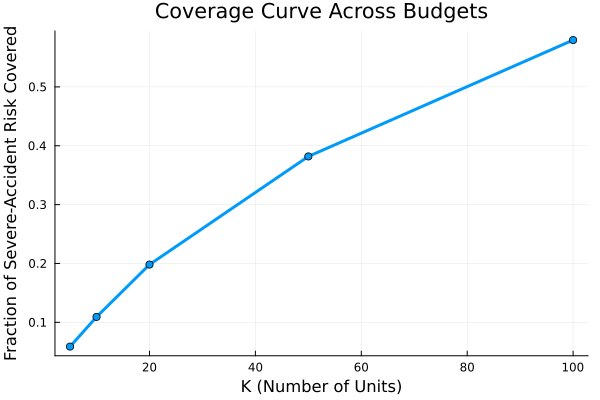

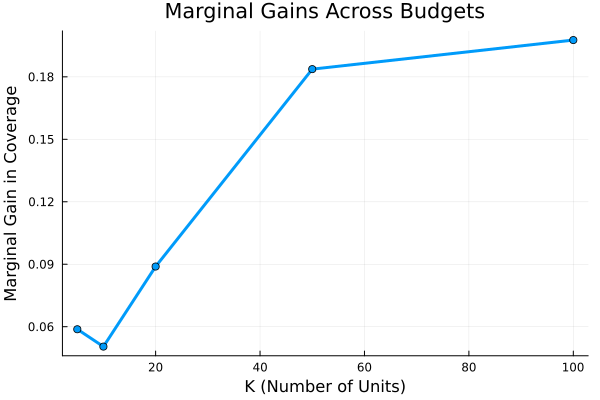

In [35]:
results_slim = select(results, :K, :frac_covered)

# Vectors for plotting
K_vec   = results_slim.K
cov_vec = results_slim.frac_covered

coverage_plot = plot(
    K_vec, cov_vec;
    xlabel = "K (Number of Units)",
    ylabel = "Fraction of Severe-Accident Risk Covered",
    title  = "Coverage Curve Across Budgets",
    lw = 3, marker = :circle, legend = false
)
display(coverage_plot)

# Marginal gains if you want them
marginal_gain = [cov_vec[1]; diff(cov_vec)]
marginal_plot = plot(
    K_vec, marginal_gain;
    xlabel = "K (Number of Units)",
    ylabel = "Marginal Gain in Coverage",
    title  = "Marginal Gains Across Budgets",
    lw = 3, marker = :circle, legend = false
)
display(marginal_plot)

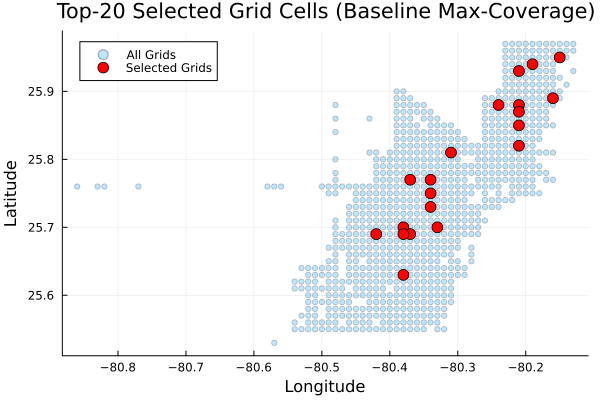

In [36]:
# Parse lat/lon from location_id once
function parse_lat_lon(id::AbstractString)
    parts = split(id, "_")  # adjust if your delimiter differs
    return parse(Float64, parts[1]), parse(Float64, parts[2])
end

latlon = map(parse_lat_lon, grouped.location_id)
grouped.lat = first.(latlon)
grouped.lon = last.(latlon)

# Choose a budget K and mark top-K cells by weight
K = 20  # change as needed
idx = partialsortperm(grouped.total_risk, 1:K; rev=true)  # indices of top-K w

grouped.selected = zeros(Int, nrow(grouped))
grouped.selected[idx] .= 1

selected = grouped[grouped.selected .== 1, :]

# Plot: all grids faint, selected in red
scatter(
    grouped.lon, grouped.lat;
    markersize = 3, alpha = 0.25, label = "All Grids",
    xlabel = "Longitude", ylabel = "Latitude",
    title = "Top-$K Selected Grid Cells (Baseline Max-Coverage)",
    aspect_ratio = :equal, legend = :topleft
)
scatter!(
    selected.lon, selected.lat;
    markersize = 6, color = :red, label = "Selected Grids"
)

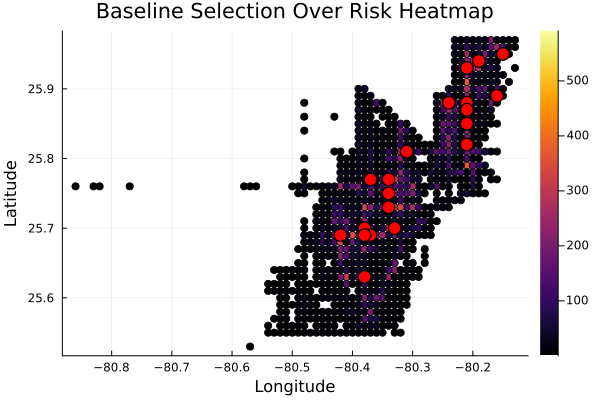

In [37]:
# Make sure c is a vector
cvals = collect(grouped.total_risk)

# Base heatmap-style scatter
p = scatter(
    grouped.lon,
    grouped.lat,
    marker_z = cvals,        
    markersize = 4,
    colorbar = true,
    xlabel = "Longitude",
    ylabel = "Latitude",
    title = "Baseline Selection Over Risk Heatmap",
    legend = false
)

# Overlay selected grids
scatter!(
    grouped.lon[grouped.selected .== 1],
    grouped.lat[grouped.selected .== 1],
    color = :red,
    markersize = 7,
    markerstrokewidth = 1.5,
    label = "Selected Grids"
)

display(p)

Each cell has a number that says how much severe-accident risk it has (w_j). We place K dots (units) on K cells for EMS to help people in severe accidents. We want to put those dots where they cover the most risk.

In the baseline, there’s no radius or elaborate “coverage” rule, we just pick the K cells with the biggest risk numbers. So the model’s job is to choose K that give the largest total risk when you add their numbers up.

Blue dots = all grid cells

Red dots = the K highest-risk cells (the ones the baseline chose)

We see red dots clustered in the hottest (most risky) parts of the map, the cells with the biggest w_j.

For each K (like 5, 10, 20, 50, 100), we solve:

“choose up to K cells” (@constraint(sum(x) ≤ K))

“maximize total risk” (@objective(Max, sum(w[j]*x[j])))

In this baseline, the solver basically ends up picking the top-K by w. We observe extremely strong spatial concentration in predicted severe-accident risk. Despite having ~840 1km² grid cells, expanding the resource budget from K=20 to K=50 covers over half the predicted risk, and K=100 covers nearly 58%. This demonstrates steep diminishing returns and highlights how a small set of targeted deployments can produce outsized improvements in coverage.

[ Info: Saved animation to /Users/AyelaChughtai/15.095/Project/baseline_selection_progress.gif


Plots.AnimatedGif("/Users/AyelaChughtai/15.095/Project/baseline_selection_progress.gif")
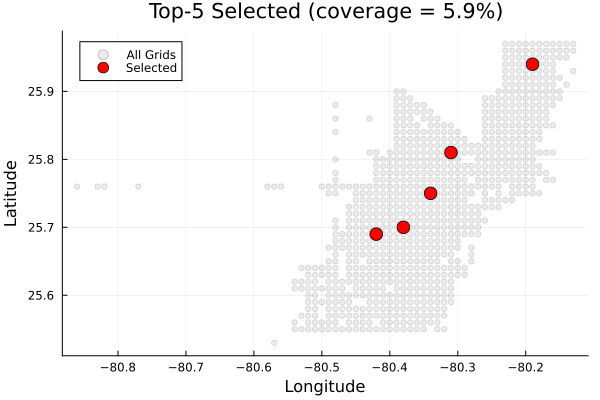

In [38]:
K_list = [5, 10, 20, 50, 100]
totrisk = sum(grouped.total_risk)

anim = @animate for K in K_list
    idx = partialsortperm(grouped.total_risk, 1:K; rev=true)
    frac = sum(grouped.total_risk[idx]) / totrisk

    p = scatter(grouped.lon, grouped.lat;
        ms=3, alpha=0.15, color=:gray, label="All Grids",
        xlabel="Longitude", ylabel="Latitude",
        aspect_ratio=:equal,
        title="Top-$K Selected (coverage = $(round(100*frac, digits=1))%)"
    )
    scatter!(grouped.lon[idx], grouped.lat[idx];
        ms=7, color=:red, label="Selected"
    )
    p
end

gif(anim, "baseline_selection_progress.gif", fps=1)

[ Info: Saved animation to /Users/AyelaChughtai/15.095/Project/baseline_selection_over_risk.gif


Plots.AnimatedGif("/Users/AyelaChughtai/15.095/Project/baseline_selection_over_risk.gif")
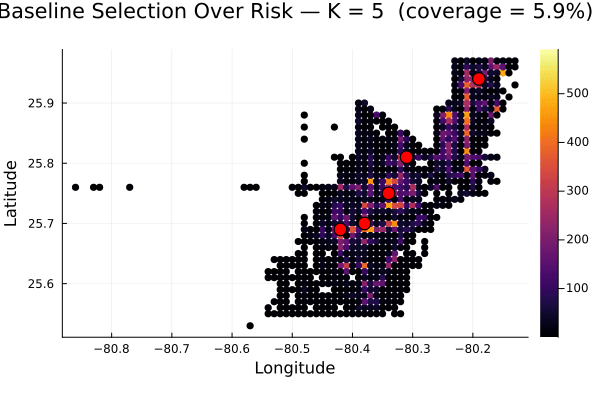

In [39]:
if !(:lat in names(grouped)) || !(:lon in names(grouped))
    function parse_lat_lon(id::AbstractString)
        parts = split(id, "_")  # adjust if your delimiter differs
        # if your ID is "lon_lat", swap the two lines below
        lat = parse(Float64, parts[1])
        lon = parse(Float64, parts[2])
        return lat, lon
    end
    latlon = map(parse_lat_lon, grouped.location_id)
    grouped.lat = first.(latlon)
    grouped.lon = last.(latlon)
end

risk = collect(grouped.total_risk)
lon  = grouped.lon
lat  = grouped.lat
K_list = [5, 10, 20, 50, 100]
totrisk = sum(risk)

# keep color scale fixed across frames
zmin, zmax = extrema(risk)

anim = @animate for K in K_list
    # Baseline: pick top-K by risk
    idx  = partialsortperm(risk, 1:K; rev=true)
    frac = sum(risk[idx]) / totrisk

    p = scatter(
        lon, lat;
        zcolor = risk, colorbar = true, c = :inferno, clims = (zmin, zmax),
        ms = 4, markerstrokewidth = 0,
        xlabel = "Longitude", ylabel = "Latitude",
        title = "Baseline Selection Over Risk — K = $K  (coverage = $(round(100*frac, digits=1))%)",
        legend = false, aspect_ratio = :equal
    )

    scatter!(lon[idx], lat[idx];
        ms = 7, color = :red, markerstrokecolor = :black, markerstrokewidth = 1.5
    )

    p
end

gif(anim, "baseline_selection_over_risk.gif", fps=1)


# Hold-Out Policy Evaluation of Prescriptive Policies

We train on **2018–2022** and evaluate decisions on the **2023** hold-out to test temporal generalization.  
For each budget $K \in \{5, 10, 20, 50, 100\}$, let $S(K)$ be the set of selected grid cells.

**Primary metric — Severe Coverage (2023):**  
What fraction of *actual* severe 2023 crashes fall inside the selected cells?
$$
\mathrm{SevereCoverage}(K)
= \frac{\#\{\,i \in 2023:\ \text{severity}_i=1,\ \text{grid}(i)\in S(K)\,\}}
       {\#\{\,i \in 2023:\ \text{severity}_i=1\,\}}.
$$

**Baselines (evaluated on 2023):**
- **Random \(K\)** cells (mean over 100 trials)
- **Historical hot-spots \(K\)** (top-\(K\) cells by **2018–2022** severe counts)

We report $\mathrm{SevereCoverage}(K)$ for **Our Policy**, **Random**, and **Historical**.  
Higher coverage than both baselines indicates the predictive–prescriptive approach finds **future** (2023) hot-spots better than chance or simply repeating the past.

Secondary check — Predicted Risk Coverage (2023):*

$$
\mathrm{RiskCoverage}(K)
= \frac{\sum_{i \in 2023,\ \text{grid}(i)\in S(K)} \hat{p}_i}
       {\sum_{i \in 2023} \hat{p}_i}.
$$

5×4 DataFrame
 Row │ K      ours       random      historical 
     │ Int64  Float64    Float64     Float64    
─────┼──────────────────────────────────────────
   1 │     5  0.0714286  0.00678571    0.214286
   2 │    10  0.0714286  0.01          0.357143
   3 │    20  0.285714   0.0196429     0.571429
   4 │    50  0.571429   0.0664286     0.571429
   5 │   100  0.642857   0.121786      0.571429

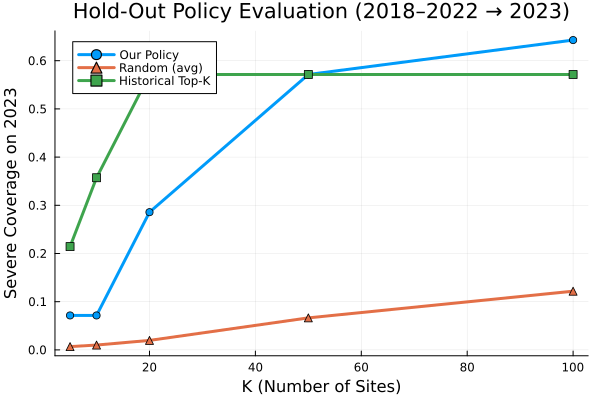

In [47]:
using DataFrames, StatsBase, Random, Plots

# assumes:
# train_df: 2018–2022 accidents with :location_id (String), :HighSeverity_int (0/1)
# test_df : 2023 accidents with :location_id (String), :HighSeverity_int (0/1)
# grouped : grid table with :location_id, :total_risk (Float64)

K_list = [5, 10, 20, 50, 100]
TRIALS = 200
Random.seed!(42)

# column aliases
ycol = :HighSeverity_int
idcol = :location_id

# policy weights and site ids
w       = collect(grouped.total_risk)
loc_ids = collect(grouped[!, idcol])
n_sites = length(loc_ids)

# our policy: top-K by model weight
function select_sites_ours(K::Int)
    return partialsortperm(w, 1:K; rev=true)  # indices of largest w
end

# historical baseline: top-K by 2018–2022 severe counts
hist_counts = combine(groupby(train_df, idcol), ycol => sum => :sev_hist)
hist_map = Dict(row[idcol] => row.sev_hist for row in eachrow(hist_counts))
sev_hist_aligned = [get(hist_map, id, 0) for id in loc_ids]
hist_order = sortperm(sev_hist_aligned; rev=true)
function select_sites_historical(K::Int)
    return hist_order[1:K]
end

# random baseline
function select_sites_random(K::Int)
    return randperm(n_sites)[1:K]
end

# severe coverage on 2023
test_severe = test_df[test_df[!, ycol] .== 1, :]
total_severe_2023 = nrow(test_severe)

function severe_coverage(selected_locids::Vector{String})
    S = Set(selected_locids)
    hits = sum(in(S), test_severe[!, idcol])
    return hits / max(1, total_severe_2023)
end

# evaluate across K
results = DataFrame(K=Int[], ours=Float64[], random=Float64[], historical=Float64[])

for K in K_list
    idx_ours = select_sites_ours(K)
    cov_ours = severe_coverage(loc_ids[idx_ours])

    cov_rand = mean(begin
        idx_r = select_sites_random(K)
        severe_coverage(loc_ids[idx_r])
    end for _ in 1:TRIALS)

    idx_hist = select_sites_historical(K)
    cov_hist = severe_coverage(loc_ids[idx_hist])

    push!(results, (K, cov_ours, cov_rand, cov_hist))
end

display(results)

# plot coverage vs K
p = plot(results.K, results.ours;
    xlabel="K (Number of Sites)",
    ylabel="Severe Coverage on 2023",
    title="Hold-Out Policy Evaluation (2018–2022 → 2023)",
    lw=3, marker=:circle, label="Our Policy"
)
plot!(results.K, results.random;     lw=3, marker=:utriangle, label="Random (avg)")
plot!(results.K, results.historical;  lw=3, marker=:square,   label="Historical Top-K")
display(p)


In [42]:
train_df

137343×93 DataFrame
    Row │ Start_Lat    Start_Lng   End_Lat     End_Lng     Distance(mi)  Tempe ⋯
        │ Float64      Float64     Float64     Float64     Float64       Float ⋯
────────┼───────────────────────────────────────────────────────────────────────
      1 │ -0.0717282    0.0327159  -0.105468    0.0336114   -0.25335           ⋯
      2 │ -1.9575      -1.07442    -1.99937    -1.06872     -0.0669115
      3 │ -1.9575      -1.07442    -1.94847    -1.06935     -0.421649
      4 │ -0.893256    -1.11702    -0.877439   -1.09484     -0.336996
      5 │ -0.684251    -1.31157    -0.678222   -1.32126     -0.369245          ⋯
      6 │ -0.263022    -0.56969    -0.265049   -0.553317    -0.385369
      7 │ -0.263668    -0.59888    -0.265788   -0.586792    -0.408548
      8 │  0.00366586  -1.31744    -0.0107675  -1.31148     -0.393432
      9 │  1.88179      1.01893     1.85594     1.00445     -0.408548          ⋯
     10 │ -0.867153    -0.650233   -0.880834   -0.703926    -0.13544
     11 │ -1.31627     -0.333589   -1.39369    -0.379387     0.187049
   ⋮    │      ⋮           ⋮           ⋮           ⋮            ⋮              ⋱
 137334 │  1.26492      1.15593     1.24743     1.14979     -0.458937
 137335 │  0.647163    -0.180722    0.700297   -0.182421    -0.00946817        ⋯
 137336 │  1.73909      1.43179     1.68924     1.40414     -0.238234
 137337 │  0.113867     0.755358    0.109108    0.825516    -0.0659037
 137338 │ -0.658158     0.25711    -0.659338    0.251516    -0.430719
 137339 │ -0.661779     0.254097   -0.654914    0.260687    -0.401494          ⋯
 137340 │  1.37397      1.15395     1.38506     1.14984     -0.252343
 137341 │  1.55533      1.12032     1.53496     1.11436     -0.458937
 137342 │  0.394202     0.825373    0.387426    0.748255    -0.073966
 137343 │  1.64186      1.28126     1.5818      1.21953     -0.0618726         ⋯
                                              88 columns and 137322 rows omitted

In the 2018–2022 data and 2023 hold-out data, we compare severe-crash coverage for three policies across budgets K = {5, 10, 20, 50, 100}. Random selection covers very little (0.7%-12.2%), confirming that targeting matters. With very small budgets, Historical Top-K (pick past hot-spots) beats our model (e.g., K=5: 21.4% vs 7.1%; K=10: 35.7% vs 7.1%), showing 2023 severe crashes remain concentrated in a few persistent locations. As K increases, our model catches up and then surpasses history (tie at K=50: 57.1%; at K=100: ours 64.3% vs history 57.1%), indicating it captures additional or shifted 2023 risk beyond what past counts alone suggest. The curve shows diminishing returns after K=50, so that is a natural “elbow” unless the extra 7 percentage points from 50-100 justify the cost; a practical approach is hybrid—seed a few sites with historical hot-spots, then allocate remaining sites with the model to track emerging risk.

In [75]:
# Parse location_id into numeric lat/lng columns
function split_lat_lng(loc)
    parts = split(loc, "_")
    lat = parse(Float64, parts[1])
    lng = parse(Float64, parts[2])
    return lat, lng
end

latitudes  = Float64[]
longitudes = Float64[]

for loc in grouped.location_id
    lat, lng = split_lat_lng(loc)
    push!(latitudes, lat)
    push!(longitudes, lng)
end

grouped.lat_bin = latitudes
grouped.lng_bin = longitudes

840-element Vector{Float64}:
 -80.21000000000001
 -80.17
 -80.21000000000001
 -80.2
 -80.21000000000001
 -80.2
 -80.2
 -80.2
 -80.17
 -80.38
 -80.21000000000001
 -80.37
 -80.3
   ⋮
 -80.3
 -80.5
 -80.28
 -80.49
 -80.5
 -80.77
 -80.46000000000001
 -80.46000000000001
 -80.19
 -80.16
 -80.38
 -80.29

# Radius-based Coverage

### Radius-Based Coverage Model (Operational Siting)

We add a response radius so a unit placed at site $\ell$ covers any demand cell $j$ within $R$ km. Let $w_j$ be the predicted severe-accident risk in cell $j$. Decisions:
- $x_\ell \in \{0,1\}$: place a unit at site $\ell$
- $y_j \in \{0,1\}$: demand cell $j$ is covered by at least one selected site

Define an incidence matrix $A_{j\ell} = 1$ if $\text{dist}(j,\ell) \le R$ and $0$ otherwise. With budget $K$, we solve:
$$
\max_{x,y}\ \sum_j w_j\, y_j
\quad \text{s.t.} \quad
\sum_\ell x_\ell \le K,\ \ 
y_j \le \sum_\ell A_{j\ell} x_\ell \ \forall j,\ \ 
x_\ell \in \{0,1\},\ y_j \in \{0,1\}.
$$

**Interpretation:** Choose up to $K$ sites to maximize total risk covered within radius $R$. On the map: light points are all grid cells, green points are covered cells ($y_j=1$), and red points are selected sites ($x_\ell=1$). Larger $K$ or $R$ increases coverage but with diminishing returns; plot the coverage fraction $\sum_j w_j y_j / \sum_j w_j$ versus $K$ (for fixed $R$) to pick a budget that balances impact and cost.


Set parameter Username
Set parameter LicenseID to value 2697020
Academic license - for non-commercial use only - expires 2026-08-20
Radius R = 3.0 km, budget K = 20
Selected sites: 20, covered cells: 492, coverage = 93.4%


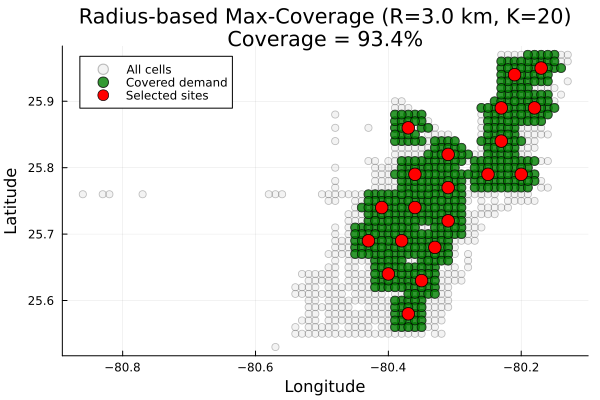

In [48]:
if !(:lat in names(grouped)) || !(:lon in names(grouped))
    function parse_lat_lon(id::AbstractString)
        p = split(id, "_")              
        return parse(Float64, p[1]), parse(Float64, p[2])
    end
    latlon = map(parse_lat_lon, grouped.location_id)
    grouped.lat = first.(latlon)
    grouped.lon = last.(latlon)
end

lat = grouped.lat
lon = grouped.lon
w   = grouped.total_risk |> collect
J   = length(w)

# build coverage incidence within radius R_km 
# crude but fine: great-circle approx via "111 km per degree" and cos(lat)
function approx_km(lat1, lon1, lat2, lon2)
    dx = (lat1 - lat2) * 111.0
    dy = (lon1 - lon2) * 111.0 * cosd((lat1 + lat2)/2)
    return sqrt(dx^2 + dy^2)
end

R_km = 3.0                           #operational radius
rows = Int[]; cols = Int[]; vals = Int[]
for j in 1:J, ℓ in 1:J
    if approx_km(lat[j], lon[j], lat[ℓ], lon[ℓ]) <= R_km
        push!(rows, j); push!(cols, ℓ); push!(vals, 1)
    end
end
A = sparse(rows, cols, vals, J, J)   # A[j,ℓ]=1 if site ℓ covers demand j

# solve max-coverage with radius for a chosen K
K = 20                                # budget

model = Model(Gurobi.Optimizer)
set_silent(model)

@variable(model, x[1:J], Bin)         # site decisions
@variable(model, y[1:J], Bin)         # covered-demand flags

@constraint(model, sum(x) <= K)
@constraint(model, [j in 1:J], y[j] <= sum(A[j,ℓ]*x[ℓ] for ℓ in 1:J))
@objective(model, Max, sum(w[j]*y[j] for j in 1:J))

optimize!(model)

sel = findall(>(0.5), value.(x))
cov = findall(>(0.5), value.(y))
frac = sum(w[cov]) / sum(w)

println("Radius R = $(R_km) km, budget K = $K")
println("Selected sites: $(length(sel)), covered cells: $(length(cov)), coverage = $(round(100*frac,digits=1))%")

# plot: covered cells (green) and chosen sites (red)
scatter(lon, lat; color=:lightgray, ms=4, alpha=0.25,
       xlabel="Longitude", ylabel="Latitude",
       title="Radius-based Max-Coverage (R=$(R_km) km, K=$K)\nCoverage = $(round(100*frac,digits=1))%",
       aspect_ratio=:equal, label="All cells")
scatter!(lon[cov], lat[cov]; color=:green, ms=5, alpha=0.8, label="Covered demand")
scatter!(lon[sel], lat[sel]; color=:red, ms=7, markerstrokecolor=:black, label="Selected sites")


Set parameter Username
Set parameter LicenseID to value 2697020
Academic license - for non-commercial use only - expires 2026-08-20
Set parameter Username
Set parameter LicenseID to value 2697020
Academic license - for non-commercial use only - expires 2026-08-20
Set parameter Username
Set parameter LicenseID to value 2697020
Academic license - for non-commercial use only - expires 2026-08-20
Set parameter Username
Set parameter LicenseID to value 2697020
Academic license - for non-commercial use only - expires 2026-08-20
Set parameter Username
Set parameter LicenseID to value 2697020
Academic license - for non-commercial use only - expires 2026-08-20


5×2 DataFrame
 Row │ K      frac_covered 
     │ Int64  Float64      
─────┼─────────────────────
   1 │     5      0.444709
   2 │    10      0.701365
   3 │    20      0.934193
   4 │    50      1.0
   5 │   100      1.0

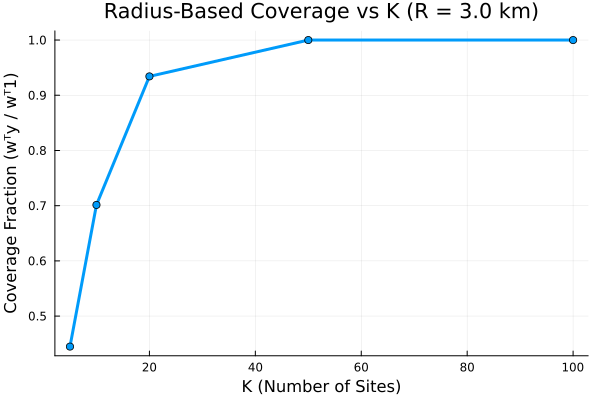

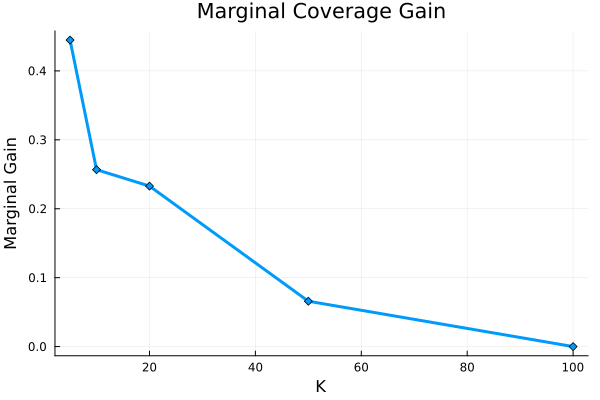

In [49]:
lat = grouped.lat
lon = grouped.lon
w   = collect(grouped.total_risk)
J   = length(w)
Wtot = sum(w)

# crude distance (km) using 111 km/deg
function approx_km(lat1, lon1, lat2, lon2)
    dx = (lat1 - lat2) * 111.0
    dy = (lon1 - lon2) * 111.0 * cosd((lat1 + lat2)/2)
    return sqrt(dx^2 + dy^2)
end

# build incidence A once for fixed R
R_km = 3.0
rows = Int[]; cols = Int[]; vals = Int[]
for j in 1:J, ℓ in 1:J
    if approx_km(lat[j], lon[j], lat[ℓ], lon[ℓ]) <= R_km
        push!(rows, j); push!(cols, ℓ); push!(vals, 1)
    end
end
A = sparse(rows, cols, vals, J, J)

# sweep K and record coverage fraction
K_list = [5, 10, 20, 50, 100]
results = DataFrame(K=Int[], frac_covered=Float64[])

for K in K_list
    model = Model(Gurobi.Optimizer)
    set_silent(model)

    @variable(model, x[1:J], Bin)             # site choices
    @variable(model, y[1:J], Bin)             # covered demand

    @constraint(model, sum(x) <= K)
    @constraint(model, [j in 1:J], y[j] <= sum(A[j,ℓ]*x[ℓ] for ℓ in 1:J))
    @objective(model, Max, sum(w[j]*y[j] for j in 1:J))

    optimize!(model)

    yval = value.(y)
    covered_idx = findall(>(0.5), yval)
    frac = sum(w[covered_idx]) / Wtot

    push!(results, (K, frac))
end

display(results)

# plot coverage fraction vs K
p = plot(results.K, results.frac_covered;
    xlabel = "K (Number of Sites)",
    ylabel = "Coverage Fraction (wᵀy / wᵀ1)",
    title  = "Radius-Based Coverage vs K (R = $(R_km) km)",
    lw=3, marker=:circle, legend=false
)
display(p)

# marginal gains plot
mg = [results.frac_covered[1]; diff(results.frac_covered)]
p2 = plot(results.K, mg; xlabel="K", ylabel="Marginal Gain", title="Marginal Coverage Gain", lw=3, marker=:diamond, legend=false)
display(p2)


With a 3 km response radius, the radius-based model covers most risk with relatively few sites and then saturates. At K=5, it covers 44.5% of total weighted risk; at K=10, 70.1%; at K=20, 93.4%; and by K=50 it reaches 100% (no further gain at K=100). The map shows that each selected site (red) covers a cluster of nearby demand cells (green), so early sites produce large gains because they sit in the densest hotspots; later sites add only small pockets of uncovered cells. The marginal-gain curve drops sharply (big jump from 5→10, smaller from 10 to 20, tiny by 20 to 50), indicating strong diminishing returns and a natural “elbow” around K=20–50. Practically, K=20 already achieves ~93% coverage; increasing to K=50 achieves full coverage, and additional sites beyond that do not improve coverage under this radius.